In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [4]:
imgs_path = "../src/imgs"

# Helper functions

In [99]:
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points


def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            if dataset_name == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            if datasets == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        df["num_evaluations"] = len(df.fitness.apply(literal_eval).apply(np.array)[0])*60
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
        
        df["gini_index"] = get_gini_coefficients(df)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.gini_index)
        df["gini_mean"] = mean_f0
        df["gini_min"] = min_f0
        df["gini_max"] = max_f0
        
        
        
    return pd.concat(simulations)



def plot_2d_minmax_scaled(datapoints, labels, show_mean_eval=False, minmax_scale = True,marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA-D&C"] = {"color":"#8c564b", "marker":"o"}
    marker_kwargs["IBEA-D&C"] = {"color":"#ff7f0e", "marker":"D"}
    marker_kwargs["NSGA-III-D&C"] = {"color":"#e377c2", "marker":"s"}
    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        if minmax_scale:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        else:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max
        if "D&C" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
        if show_mean_eval:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                     round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                     round(min_f1,2),round(mean_f1,2),round(max_f1,2), round(data.num_evaluations))
        else:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
    return fig, ax
def plot_vehicle_drivetimes(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s min$" % (vehicle_amount, mean_route_time_sum))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicle nr")
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

In [6]:
def add_minmax_fuel_drivetime_columns(dataframes):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    
    datasets = dataframes[0].dataset.unique()
    for dataset in datasets:
        if not dataset in max_fuel_consumptions.keys():
            max_fuel_consumptions[dataset] = 0
            min_fuel_consumptions[dataset]  = 10e10
            max_drivetimes[dataset]  = 0
            min_drivetimes[dataset]  = 10e10
        for dataframe in dataframes:

            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()

            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()

            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel

            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel

            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime

            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
                
    for dataset in datasets:
        for dataframe in dataframes:
        
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = (dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)

            dataframe['fuel_consumption_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_fuel_consumption_scaled,dataframe.fuel_consumption_final_minmax)
            
            dataframe_longest_drivetime_scaled = (dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
            dataframe['longest_route_time_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_longest_drivetime_scaled,dataframe.longest_route_time_final_minmax)
      
            mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.fuel_consumption_final_minmax)
            dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
            dataframe["fuel_consumption_final_minmax_min"] = min_f0
            dataframe["fuel_consumption_final_minmax_max"] = max_f0

            mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.longest_route_time_final_minmax)
            dataframe["longest_route_time_final_minmax_mean"] = mean_f0
            dataframe["longest_route_time_final_minmax_min"] = min_f0
            dataframe["longest_route_time_final_minmax_max"] = max_f0


In [7]:
def add_minmax_fuel_drivetime_columns(dataframes,datasets = None):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    if datasets == None:
        datasets = dataframes[0].dataset.unique()
        
    for dataset in datasets:
        if not dataset in max_fuel_consumptions.keys():
            max_fuel_consumptions[dataset] = 0
            min_fuel_consumptions[dataset]  = 10e10
            max_drivetimes[dataset]  = 0
            min_drivetimes[dataset]  = 10e10
        for dataframe in dataframes:

            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()

            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()

            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel

            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel

            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime

            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
    for dataframe in dataframes:
        fuel_minmax = []  
        longest_minmax = []
        
        for dataset in datasets:
       
        
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = np.array((dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption))
            fuel_minmax.extend(dataframe_fuel_consumption_scaled[np.where(dataframe.dataset == dataset)])
            
            dataframe_longest_drivetime_scaled = np.array((dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final))
            longest_minmax.extend(dataframe_longest_drivetime_scaled[np.where(dataframe.dataset == dataset)])

      
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(fuel_minmax)
        dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
        dataframe["fuel_consumption_final_minmax_min"] = min_f0
        dataframe["fuel_consumption_final_minmax_max"] = max_f0

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(longest_minmax)
        dataframe["longest_route_time_final_minmax_mean"] = mean_f0
        dataframe["longest_route_time_final_minmax_min"] = min_f0
        dataframe["longest_route_time_final_minmax_max"] = max_f0




In [8]:
import time 
start_time = time.monotonic()

print("SA")
SA_data_time_limited = combine_datasets("SA", "time_limited_test_data/")
print("GA")
GA_data_time_limited = combine_datasets("GA", "time_limited_test_data/")
print("NSGA2")
NSGA2_data_time_limited = combine_datasets("NSGA2", "time_limited_test_data/")
print("NSGA3")
NSGA3_data_time_limited = combine_datasets("NSGA3", "time_limited_test_data/")
print("UNSGA3")
UNSGA3_data_time_limited = combine_datasets("UNSGA3", "time_limited_test_data/")
print("IBEA")
IBEA_data_time_limited = combine_datasets("IBEA", "time_limited_test_data/")

add_minmax_fuel_drivetime_columns([SA_data_time_limited,GA_data_time_limited,
                                   NSGA2_data_time_limited,NSGA3_data_time_limited,
                                   UNSGA3_data_time_limited,IBEA_data_time_limited])

SA_data_time_limited_mean = SA_data_time_limited.mean()
GA_data_time_limited_mean = GA_data_time_limited.mean()
NSGA2_data_time_limited_mean = NSGA2_data_time_limited.mean()
NSGA3_data_time_limited_mean = NSGA3_data_time_limited.mean()
UNSGA3_data_time_limited_mean = UNSGA3_data_time_limited.mean()
IBEA_data_time_limited_mean = IBEA_data_time_limited.mean()


print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  2.72922717199981


In [9]:
import time 
start_time = time.monotonic()
print("SA")
SA_data_evaluation_limited = combine_datasets("SA", "parameter_data/reruns/")
#SA_data_evaluation_limited = SA_data_evaluation_limited.where(SA_data_evaluation_limited["Parameter Group"] == 4).dropna()
print("GA")
GA_data_evaluation_limited = combine_datasets("GA", "parameter_data/reruns/")
#GA_data_evaluation_limited = GA_data_evaluation_limited.where(GA_data_evaluation_limited["Parameter Group"] == 38).dropna()
print("NSGA2")
NSGA2_data_evaluation_limited = combine_datasets("NSGA2", "parameter_data/reruns_L1/")
print("NSGA3")
NSGA3_data_evaluation_limited = combine_datasets("NSGA3", "parameter_data/reruns_L1/")
print("UNSGA3")
UNSGA3_data_evaluation_limited = combine_datasets("UNSGA3", "parameter_data/reruns_L1/")
print("IBEA")
IBEA_data_evaluation_limited = combine_datasets("IBEA", "parameter_data/reruns_L1/")
add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited,GA_data_evaluation_limited,
                                   NSGA2_data_evaluation_limited,NSGA3_data_evaluation_limited,
                                   UNSGA3_data_evaluation_limited,IBEA_data_evaluation_limited])
SA_data_evaluation_limited_mean = SA_data_evaluation_limited.mean()
GA_data_evaluation_limited_mean = GA_data_evaluation_limited.mean()
NSGA2_data_evaluation_limited_mean = NSGA2_data_evaluation_limited.mean()
NSGA3_data_evaluation_limited_mean = NSGA3_data_evaluation_limited.mean()
UNSGA3_data_evaluation_limited_mean = UNSGA3_data_evaluation_limited.mean()
IBEA_data_evaluation_limited_mean = IBEA_data_evaluation_limited.mean()
print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  3.230766823999147


# Plot Time limited to 5s

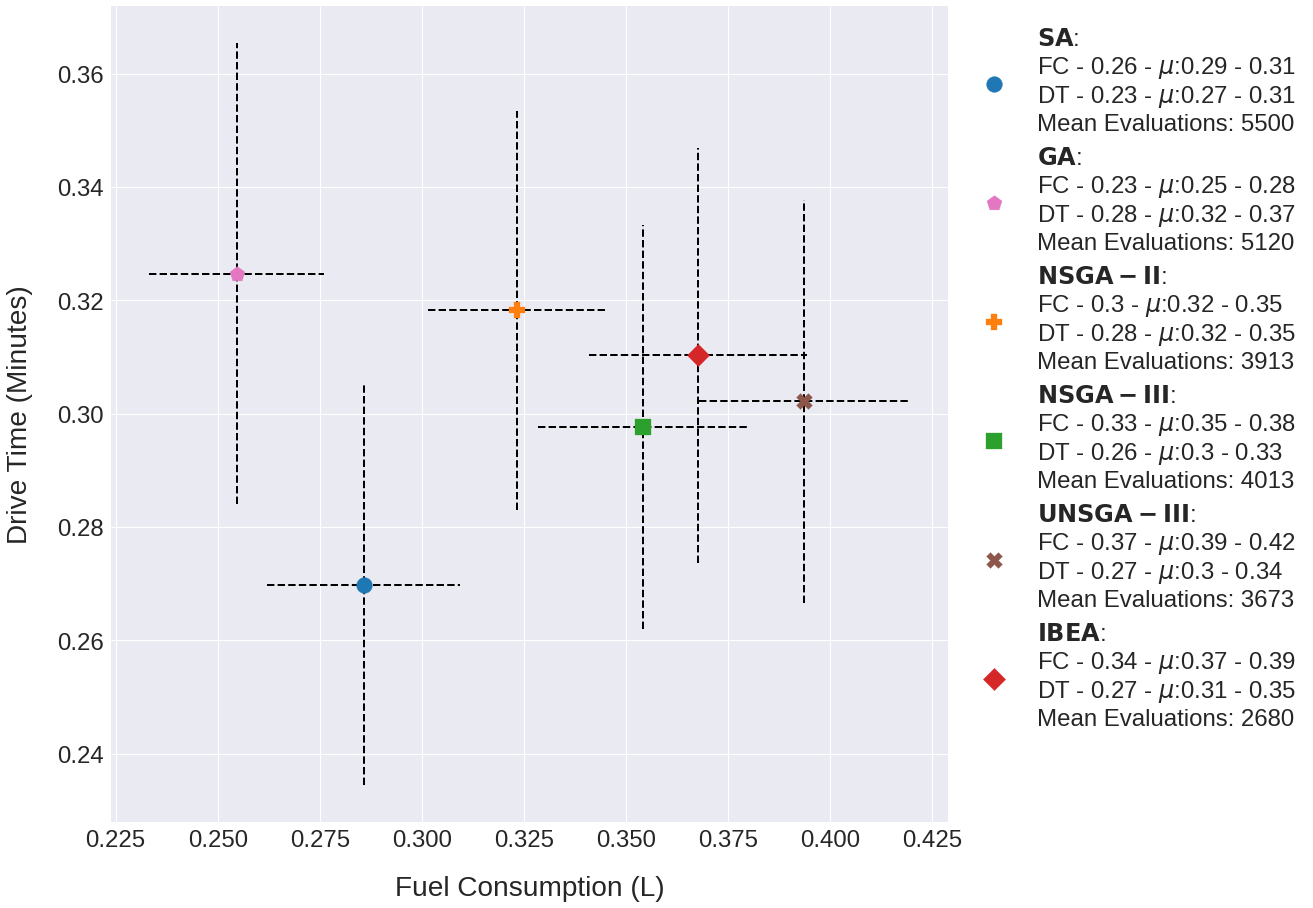

In [10]:
algorithms = [SA_data_time_limited_mean, GA_data_time_limited_mean, NSGA2_data_time_limited_mean, NSGA3_data_time_limited_mean, UNSGA3_data_time_limited_mean, IBEA_data_time_limited_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels, show_mean_eval=True)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_time_limited_{}.pdf".format("combined"),bbox_inches='tight')
plt.show()

In [11]:
fig.savefig("{}/confidence_plot_2d_5s_time_limited.pdf".format(imgs_path), bbox_inches='tight')

# Plot Time limited to 5s for all datasets

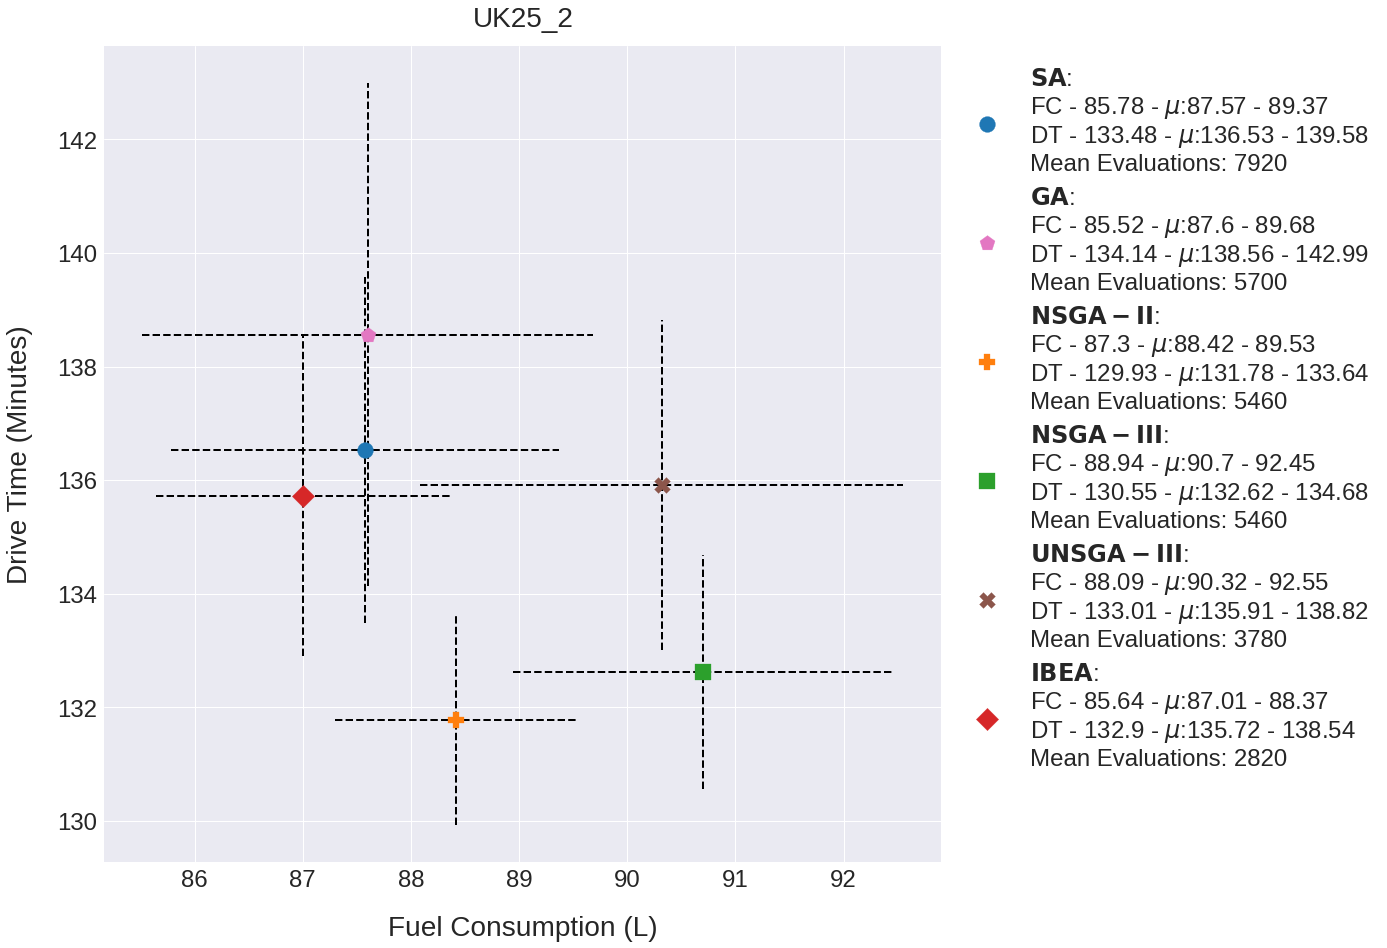

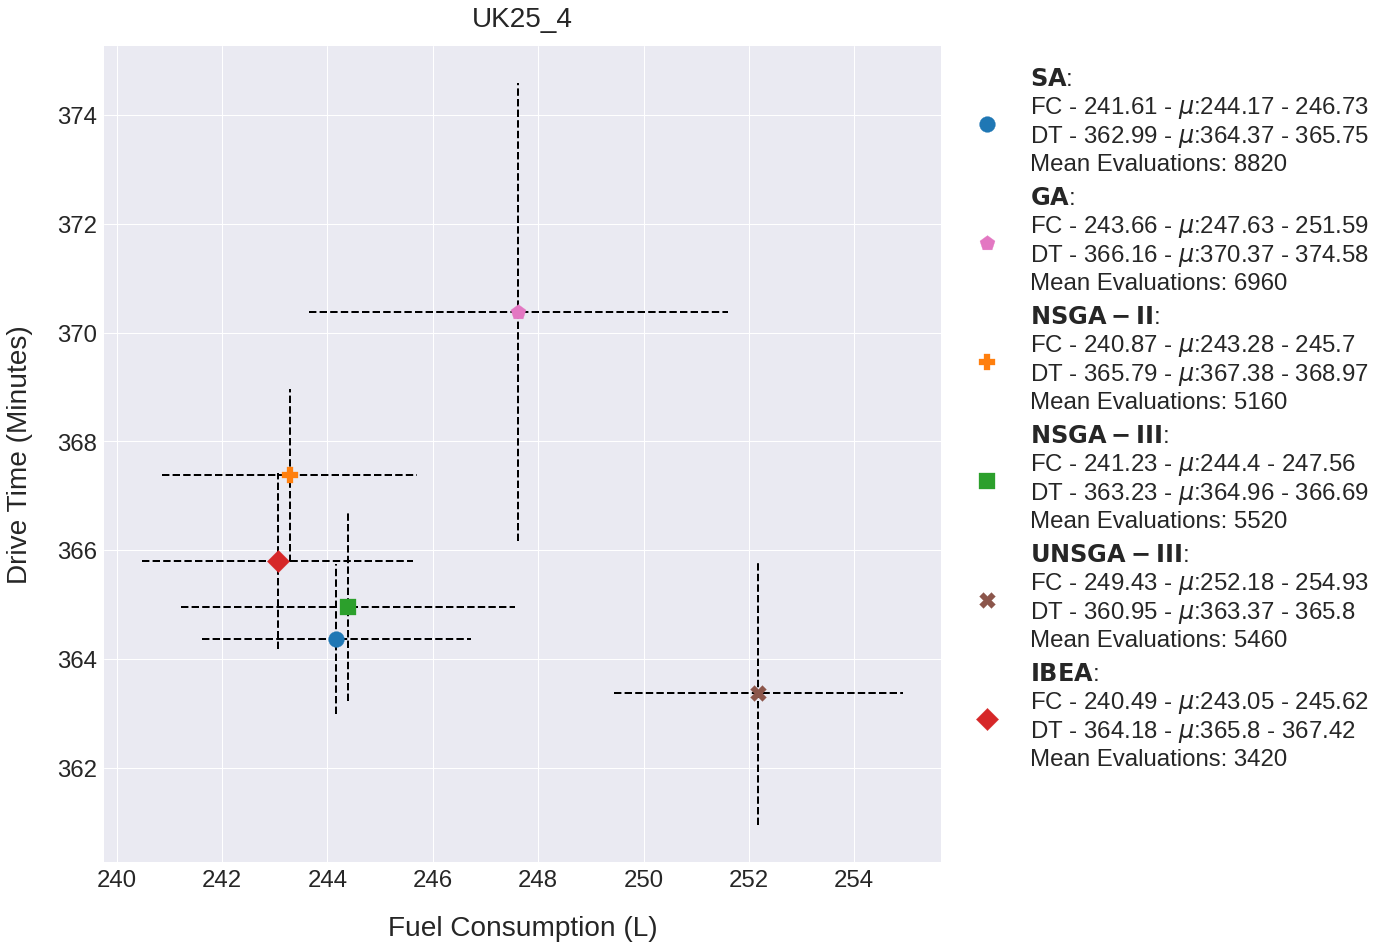

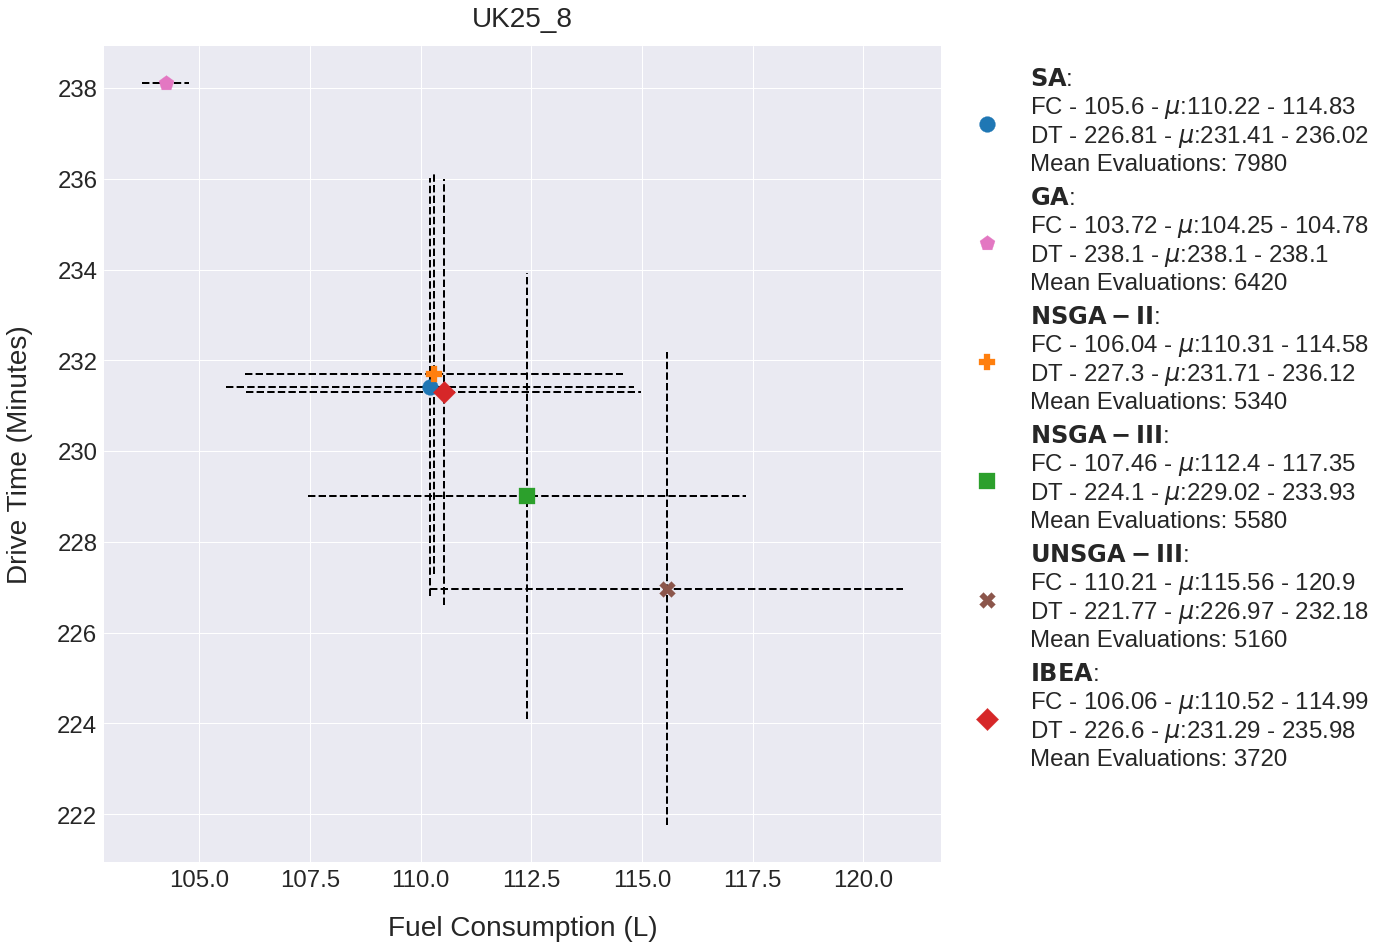

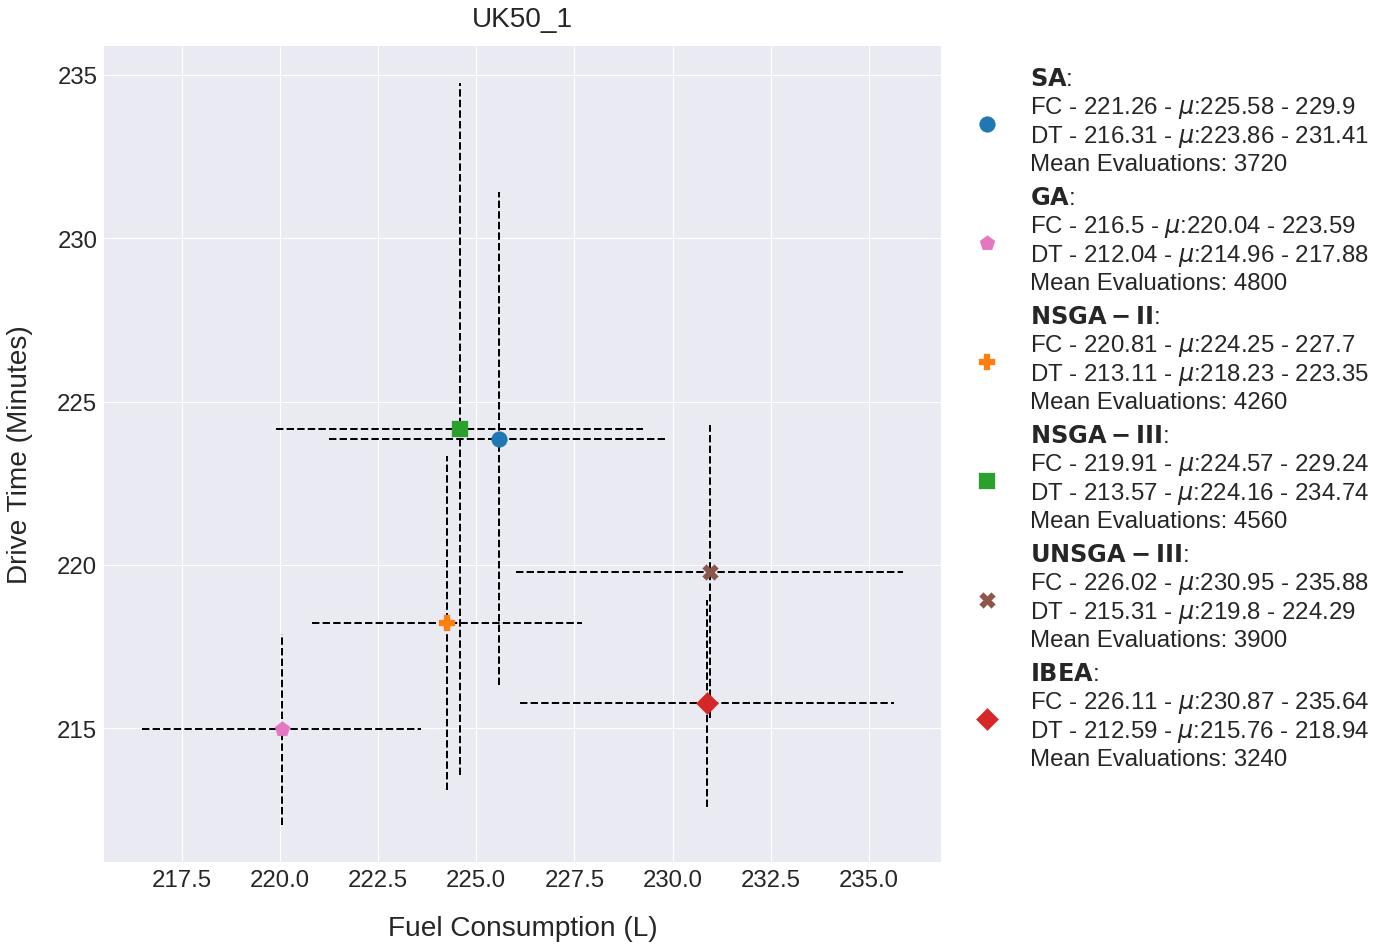

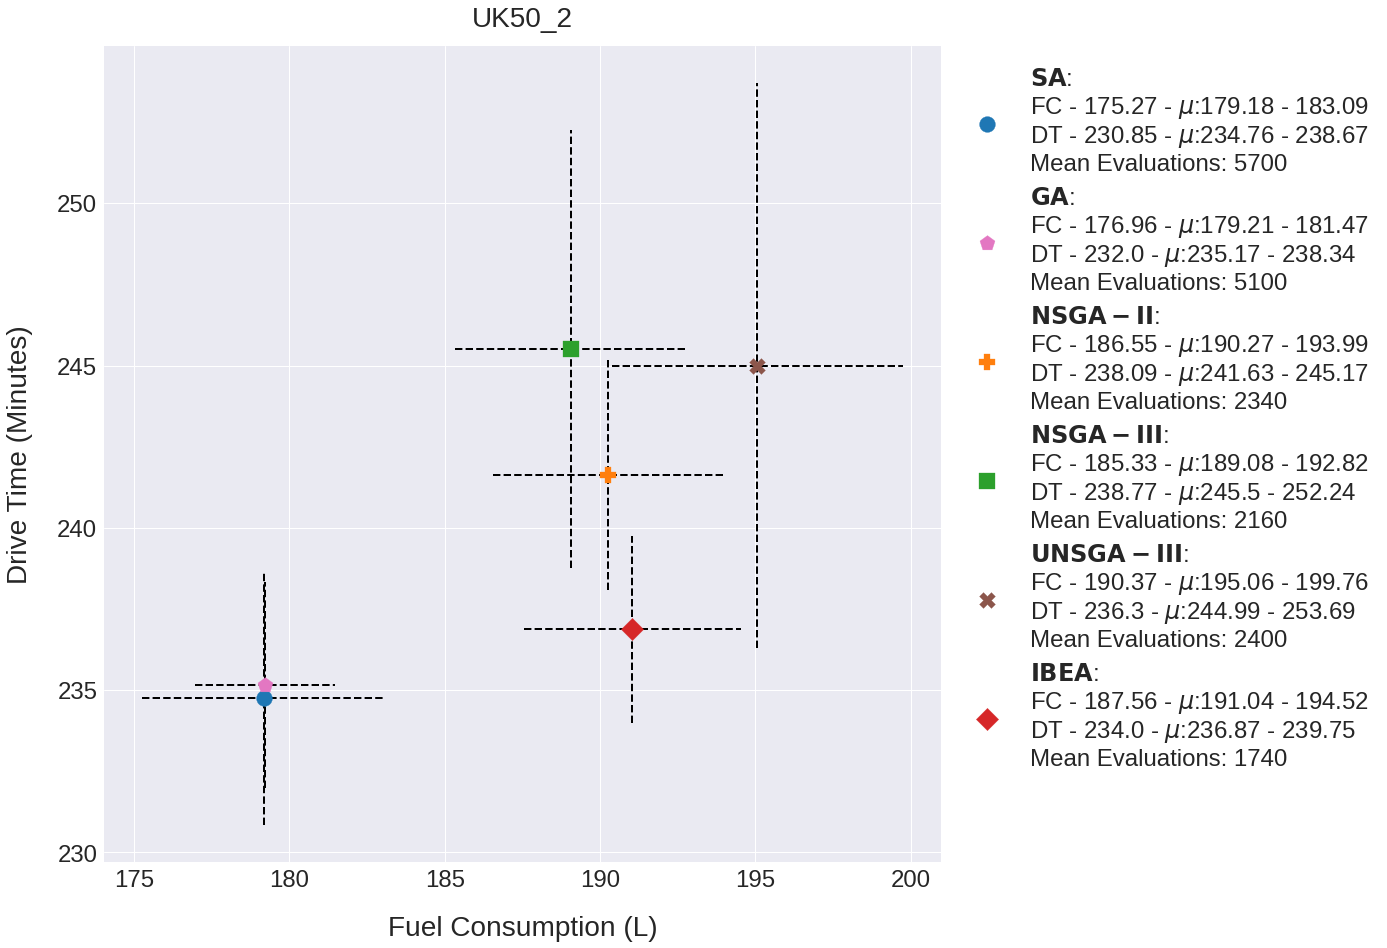

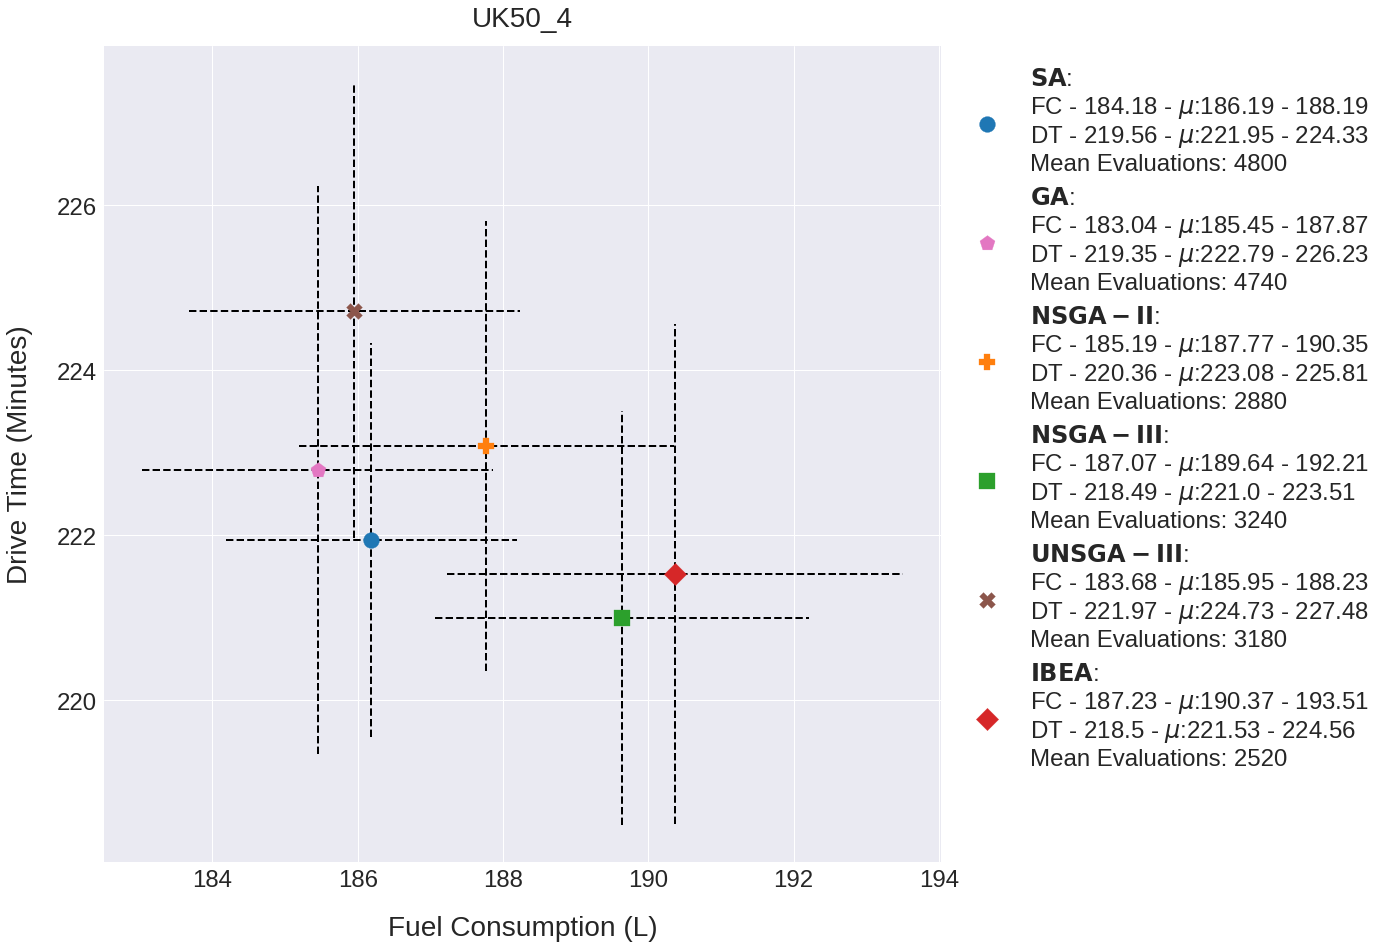

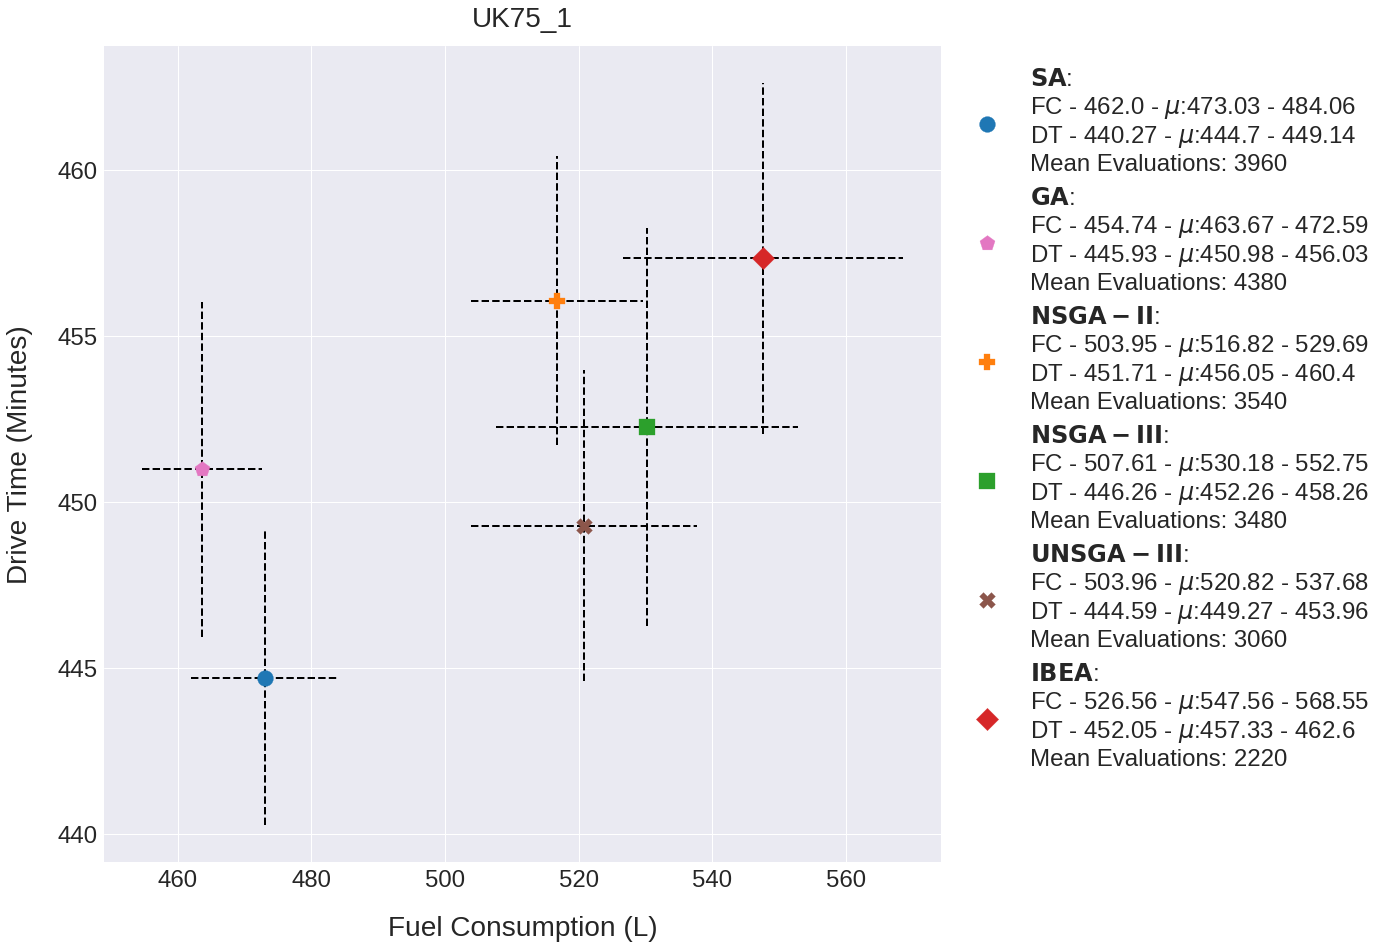

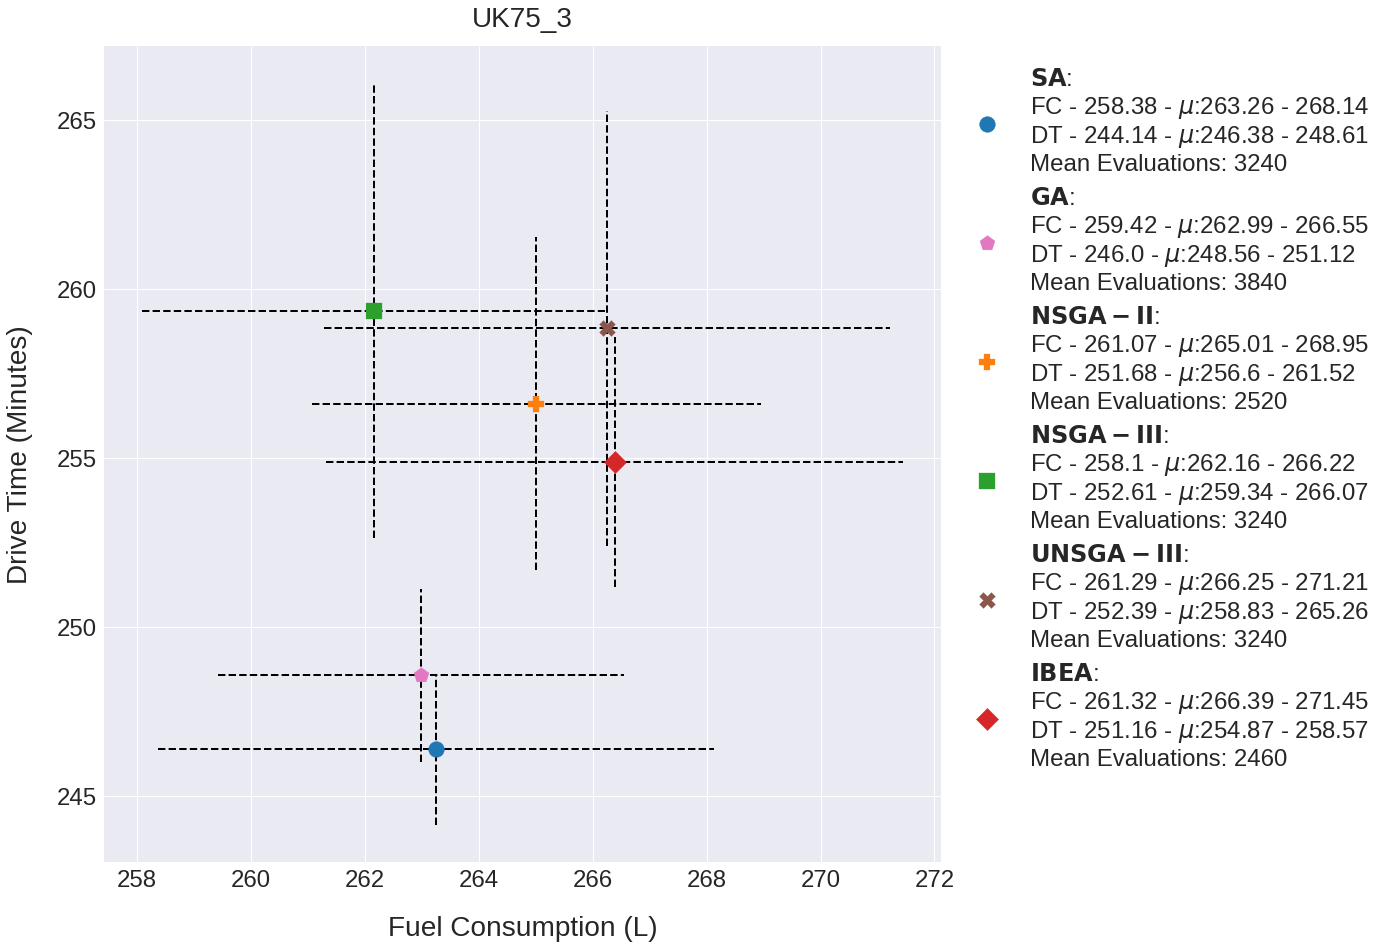

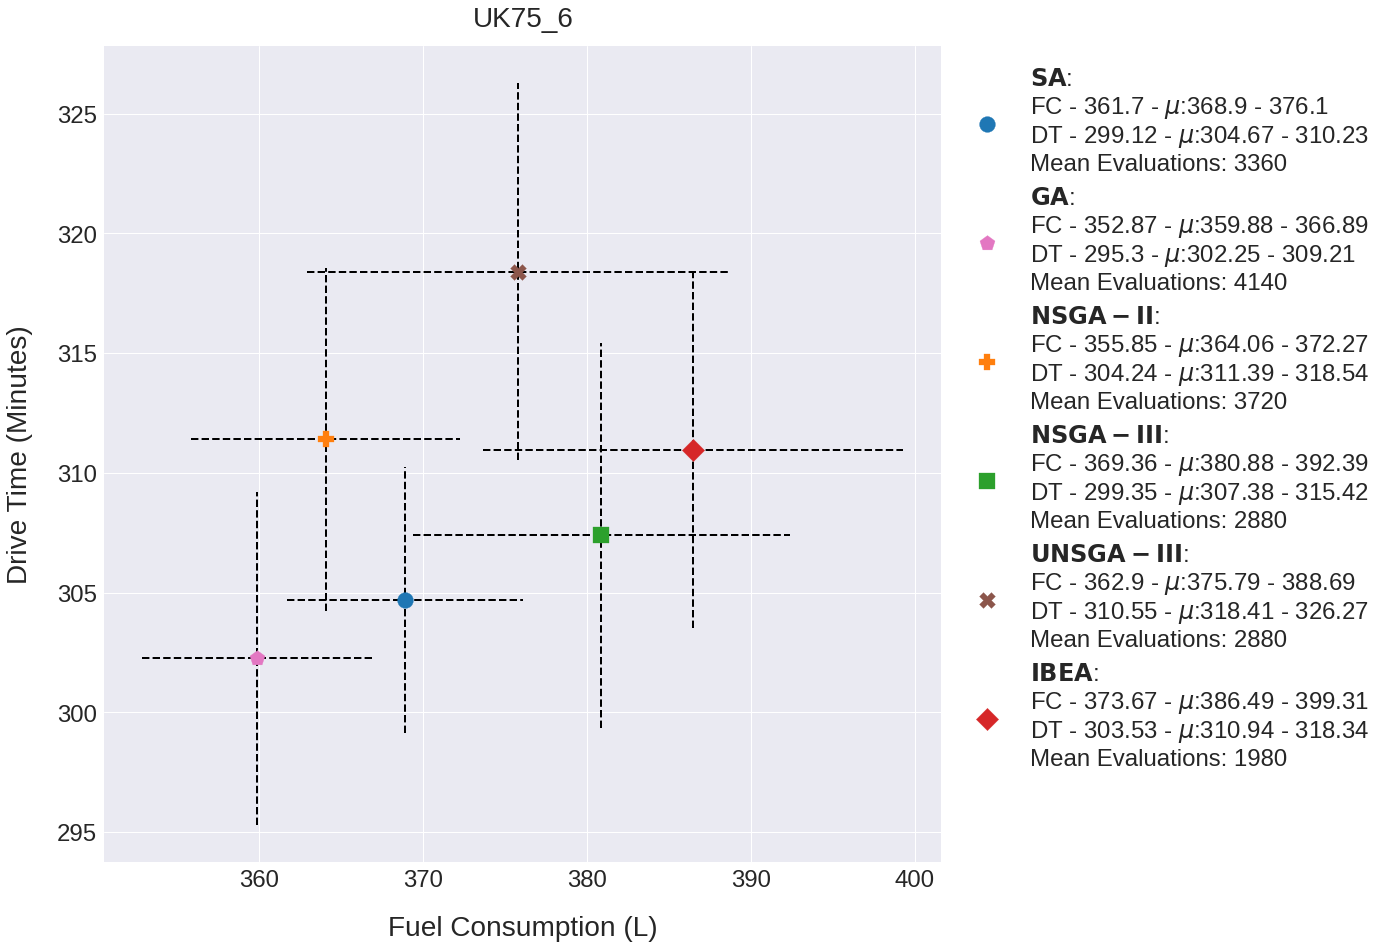

In [12]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False,show_mean_eval=True)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    #plt.savefig("2d_plot_fuel_drivetime_time_limited_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()

# Plot evaluation limited

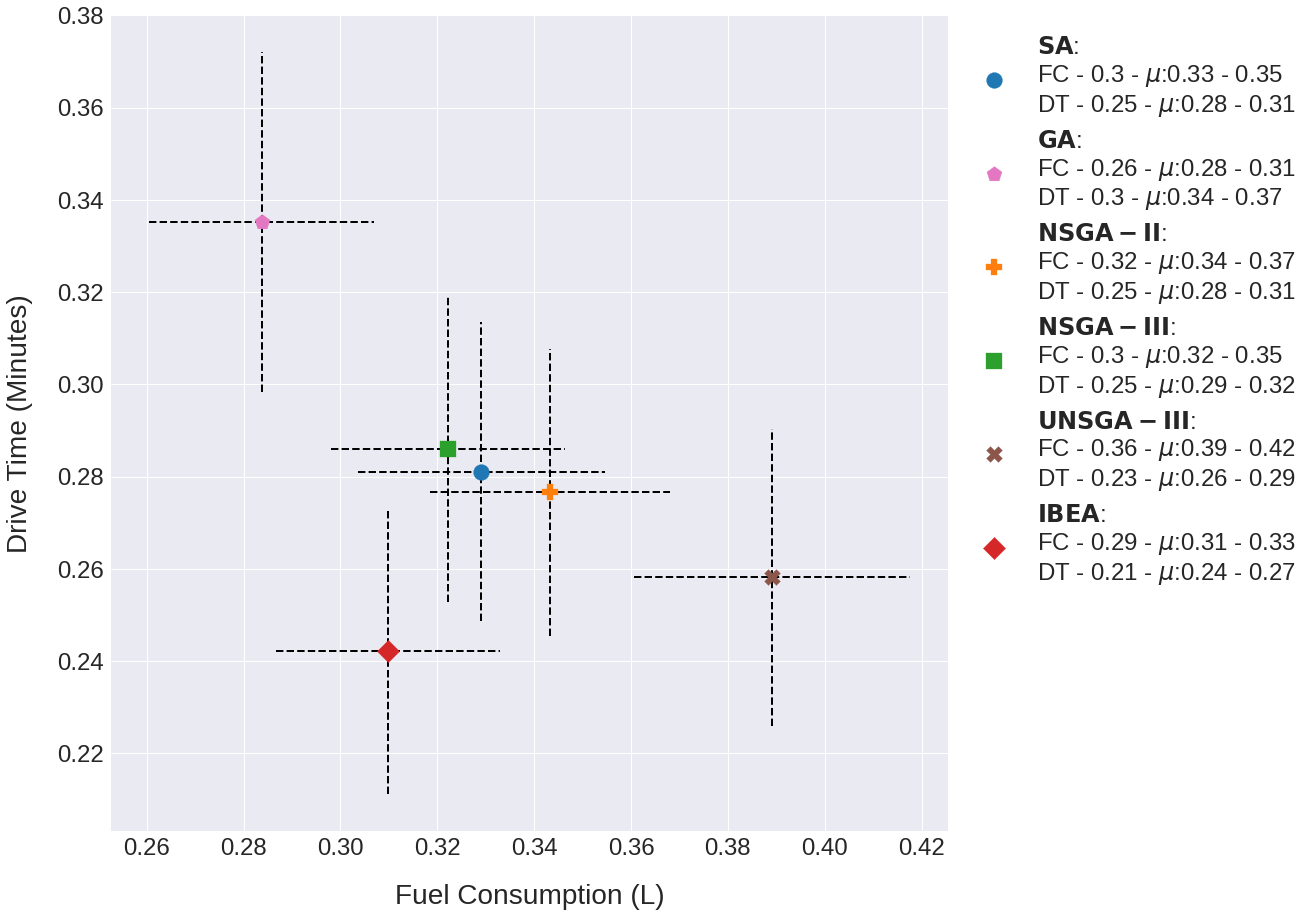

In [51]:
algorithms = [SA_data_evaluation_limited_mean, GA_data_evaluation_limited_mean, NSGA2_data_evaluation_limited_mean, NSGA3_data_evaluation_limited_mean, UNSGA3_data_evaluation_limited_mean, IBEA_data_evaluation_limited_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format("combined"),bbox_inches='tight')
#plt.tight_layout(pad=2)
plt.show()

# Plot evaluation limited for all datasets

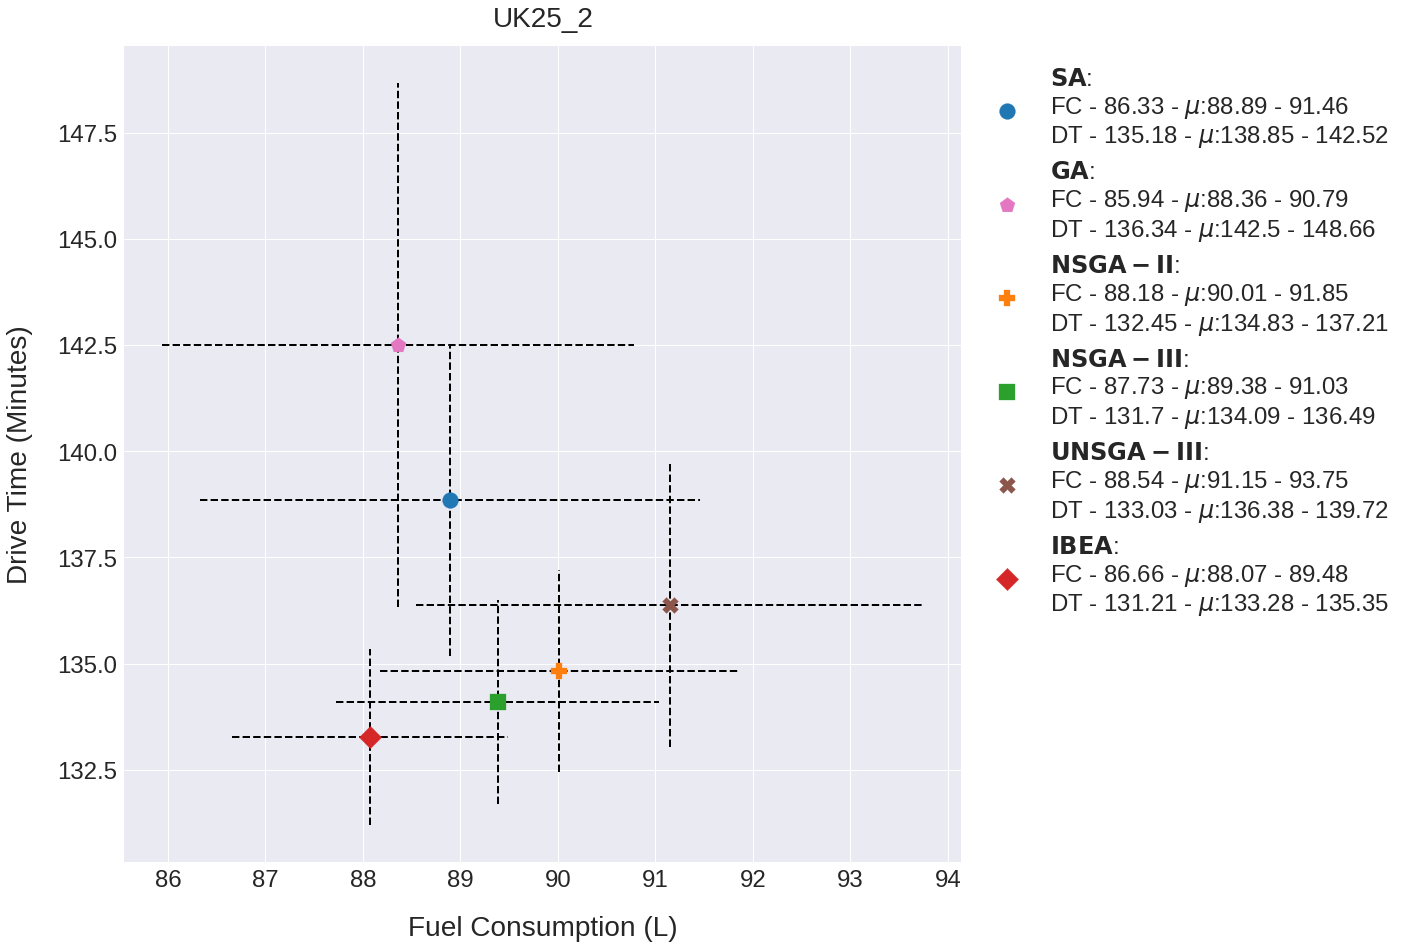

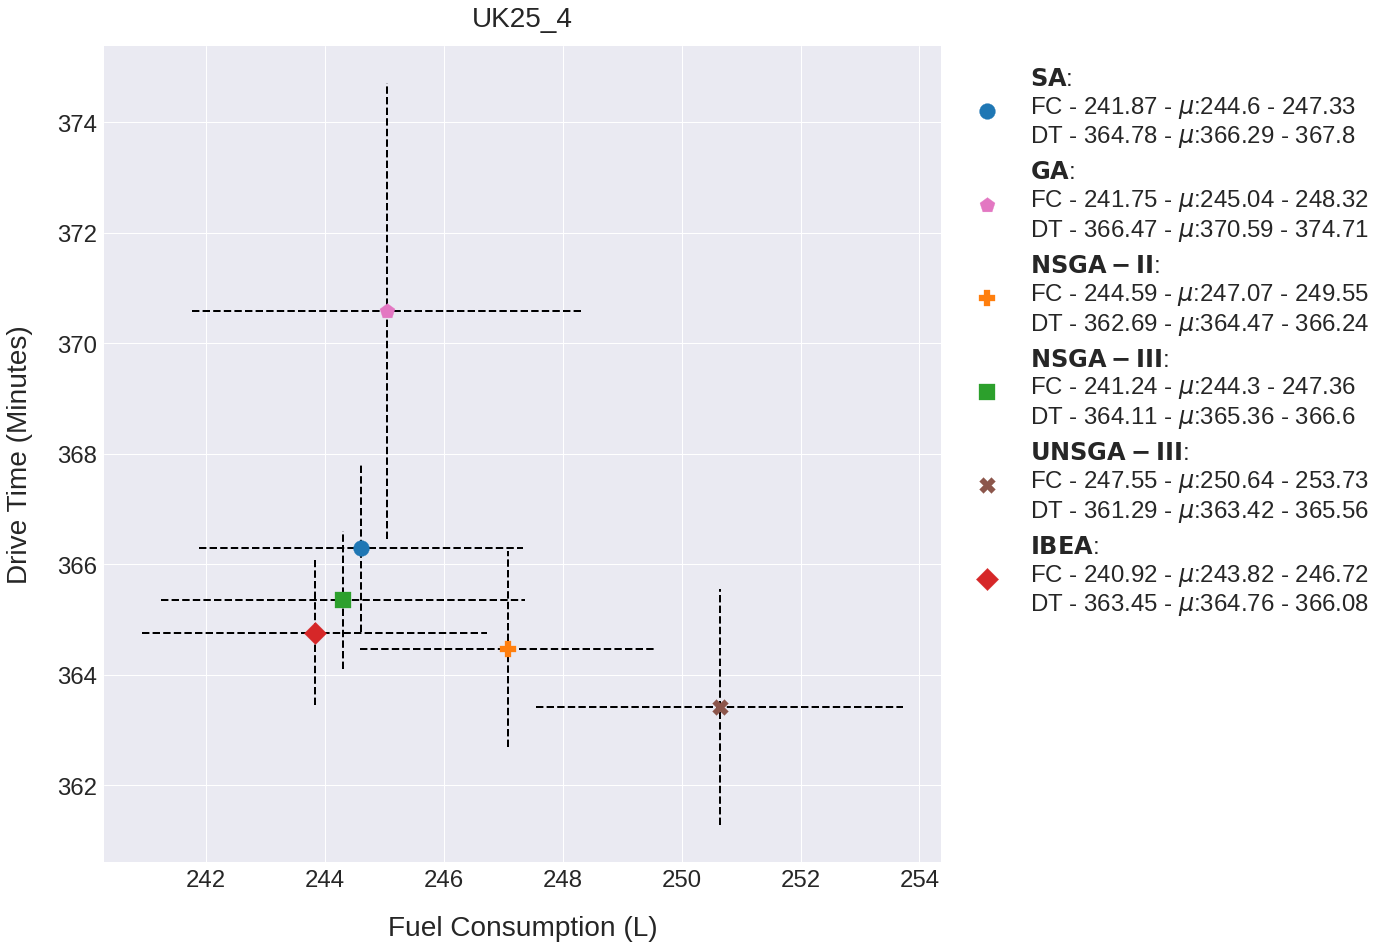

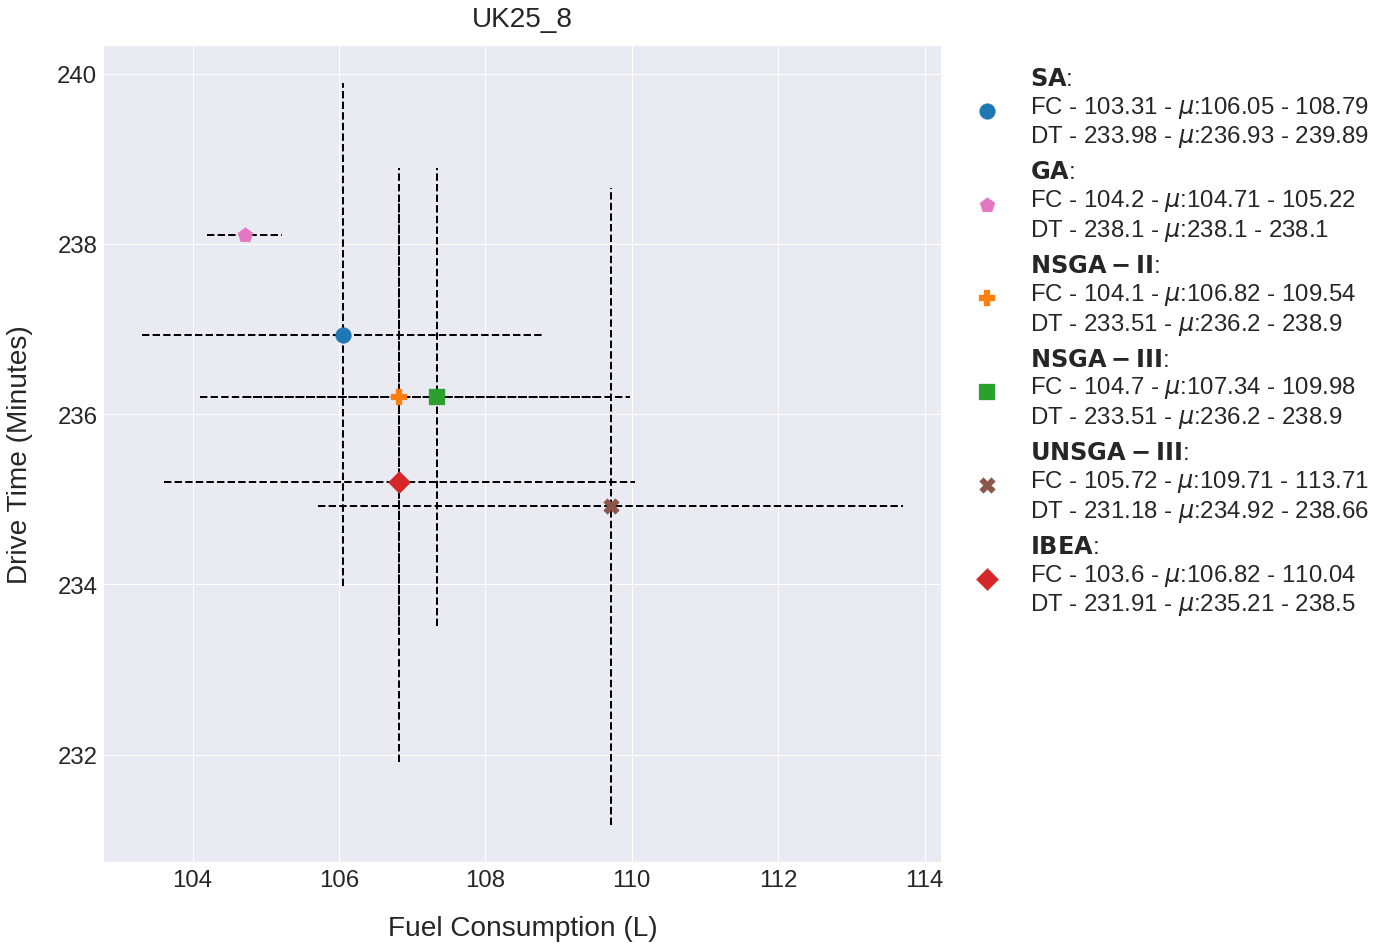

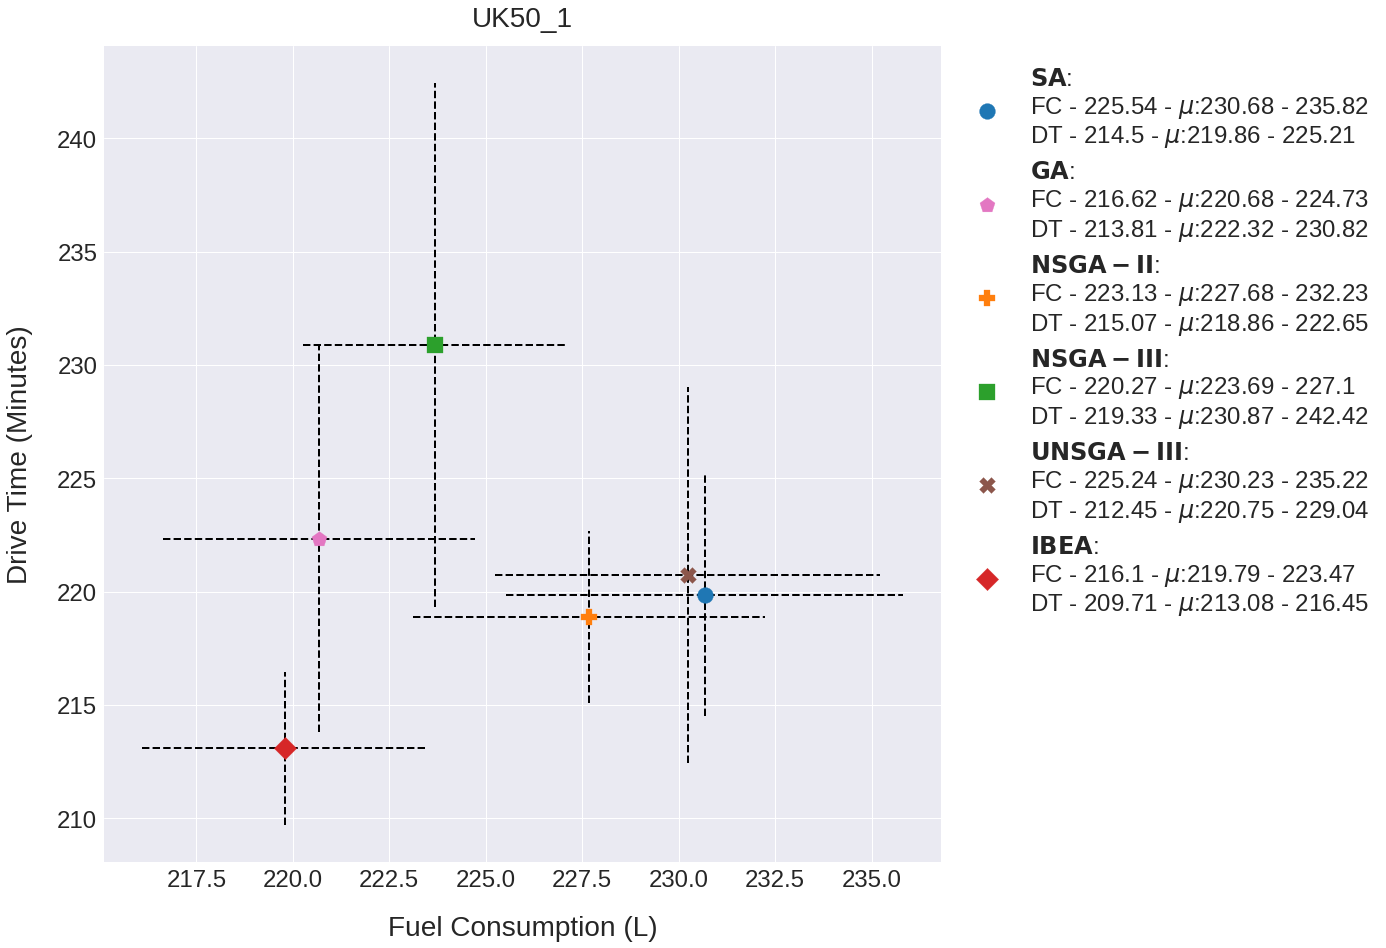

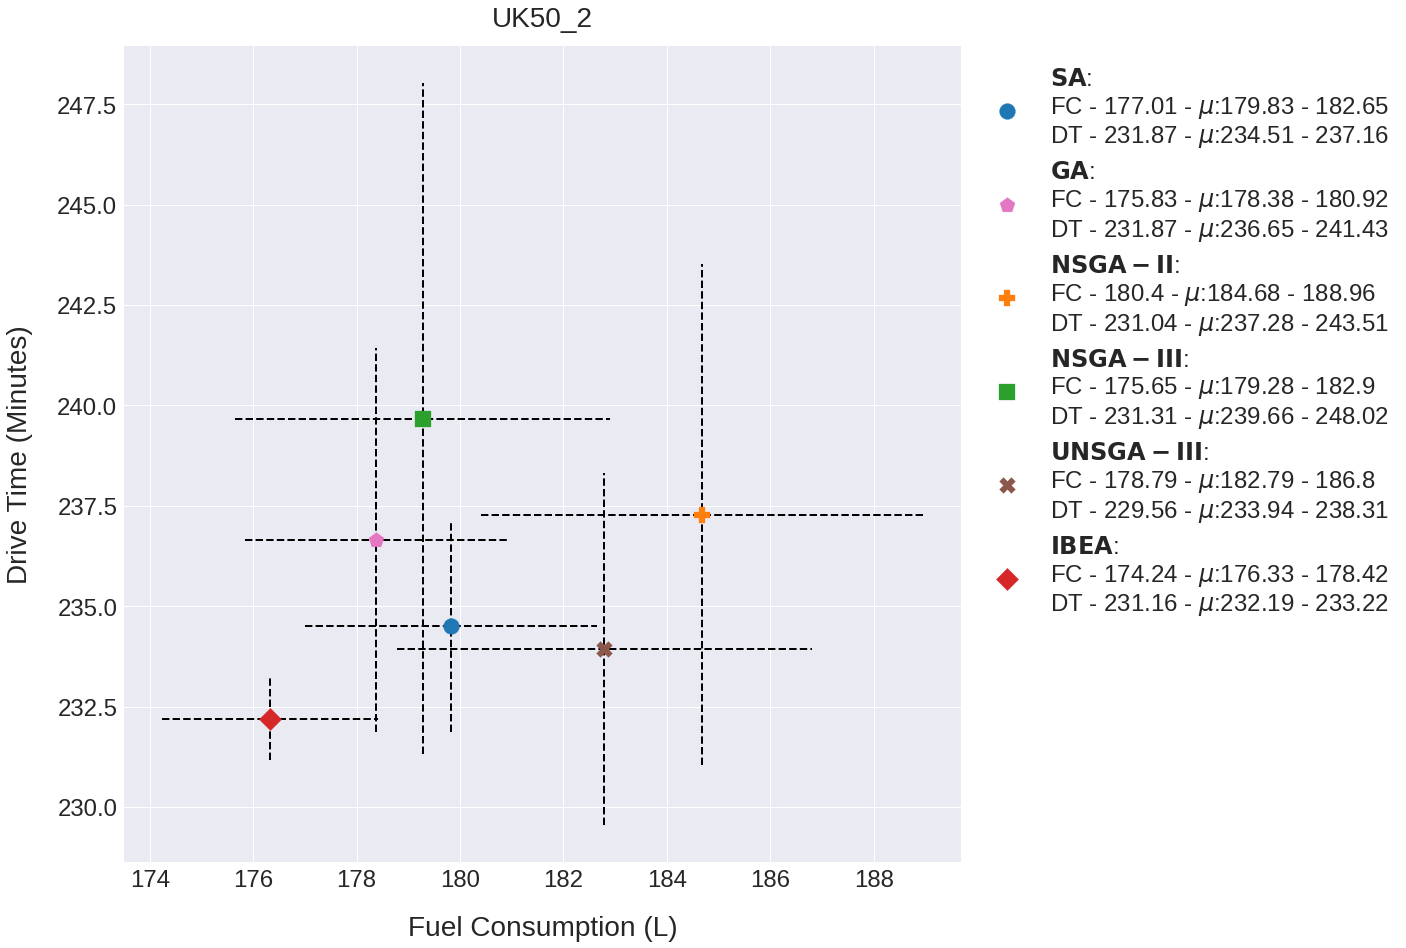

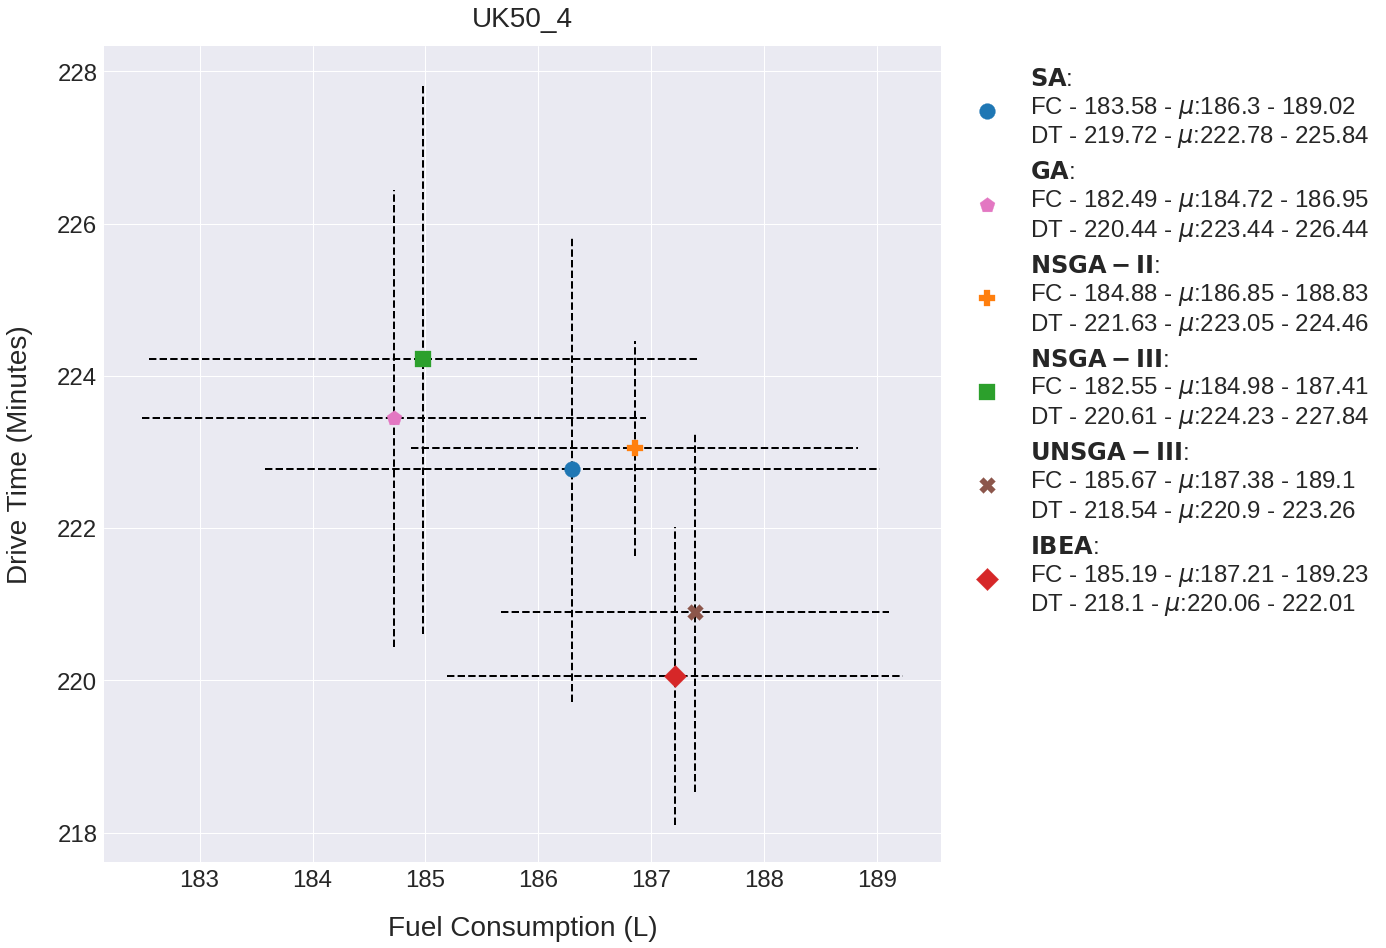

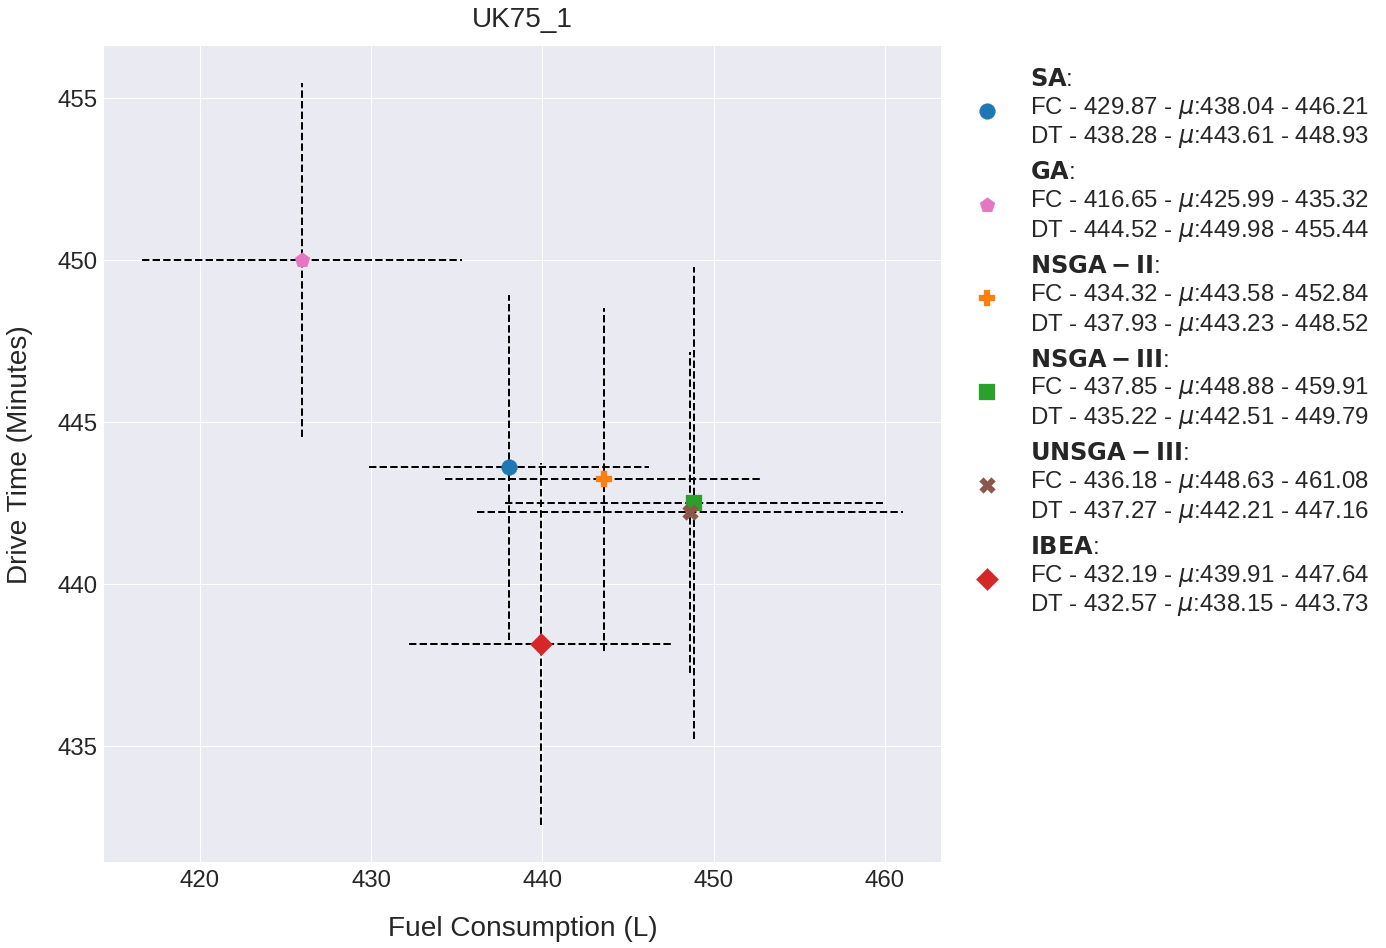

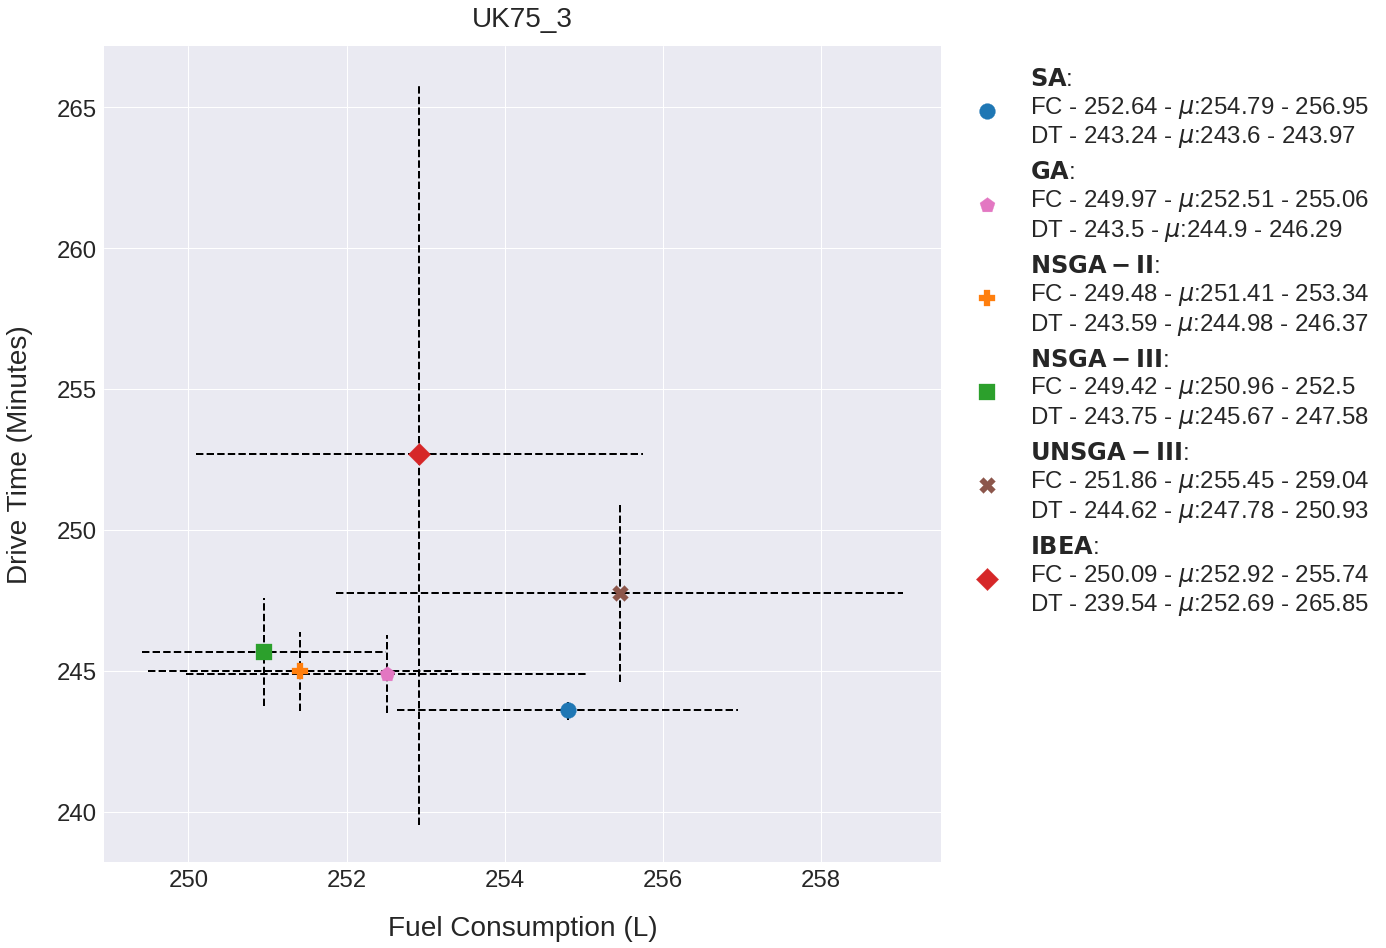

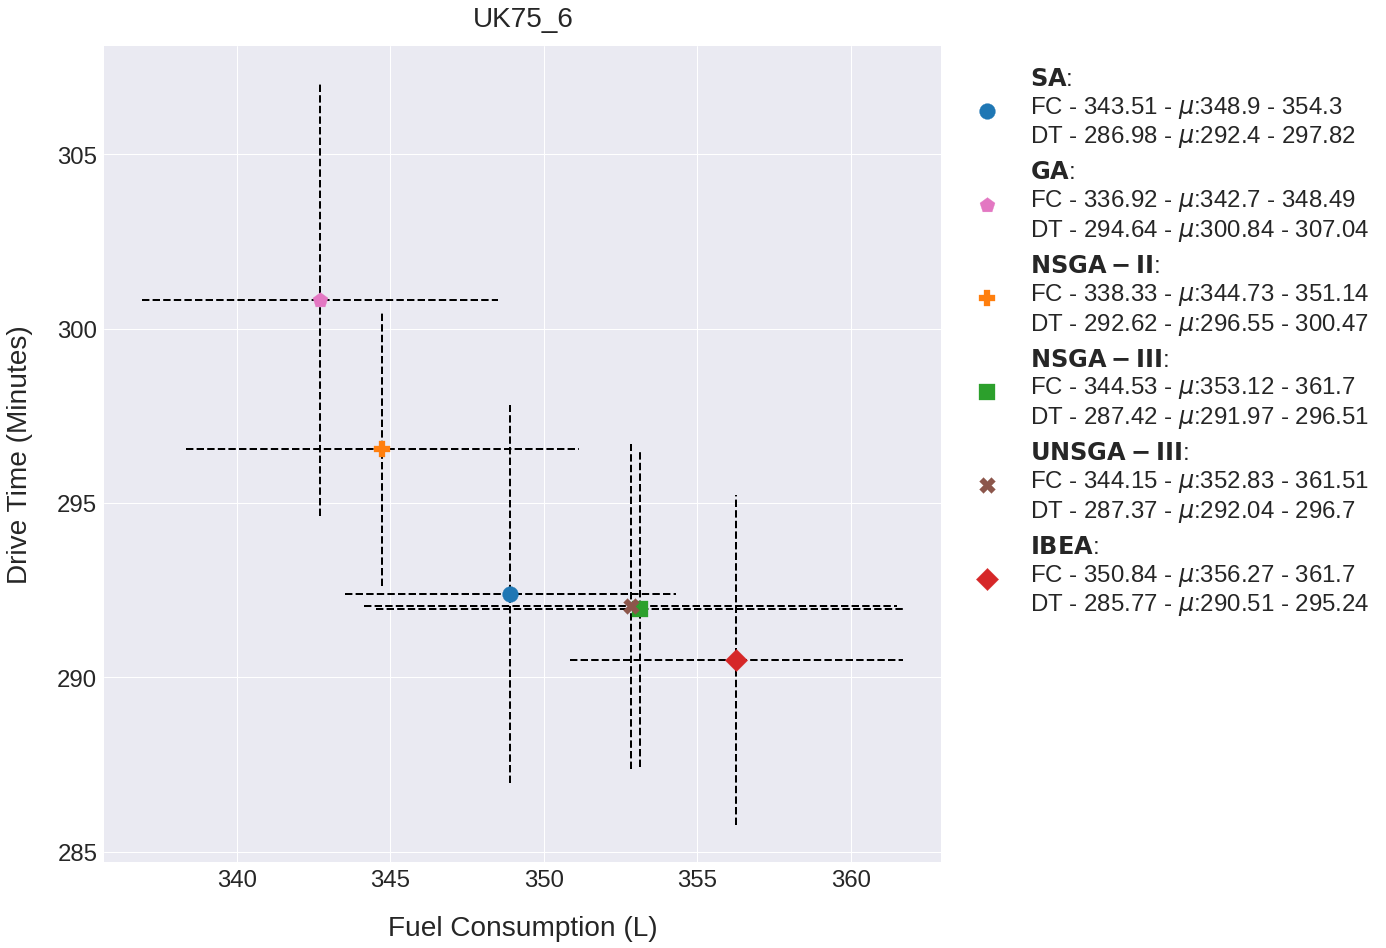

In [47]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    #plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()
    
    

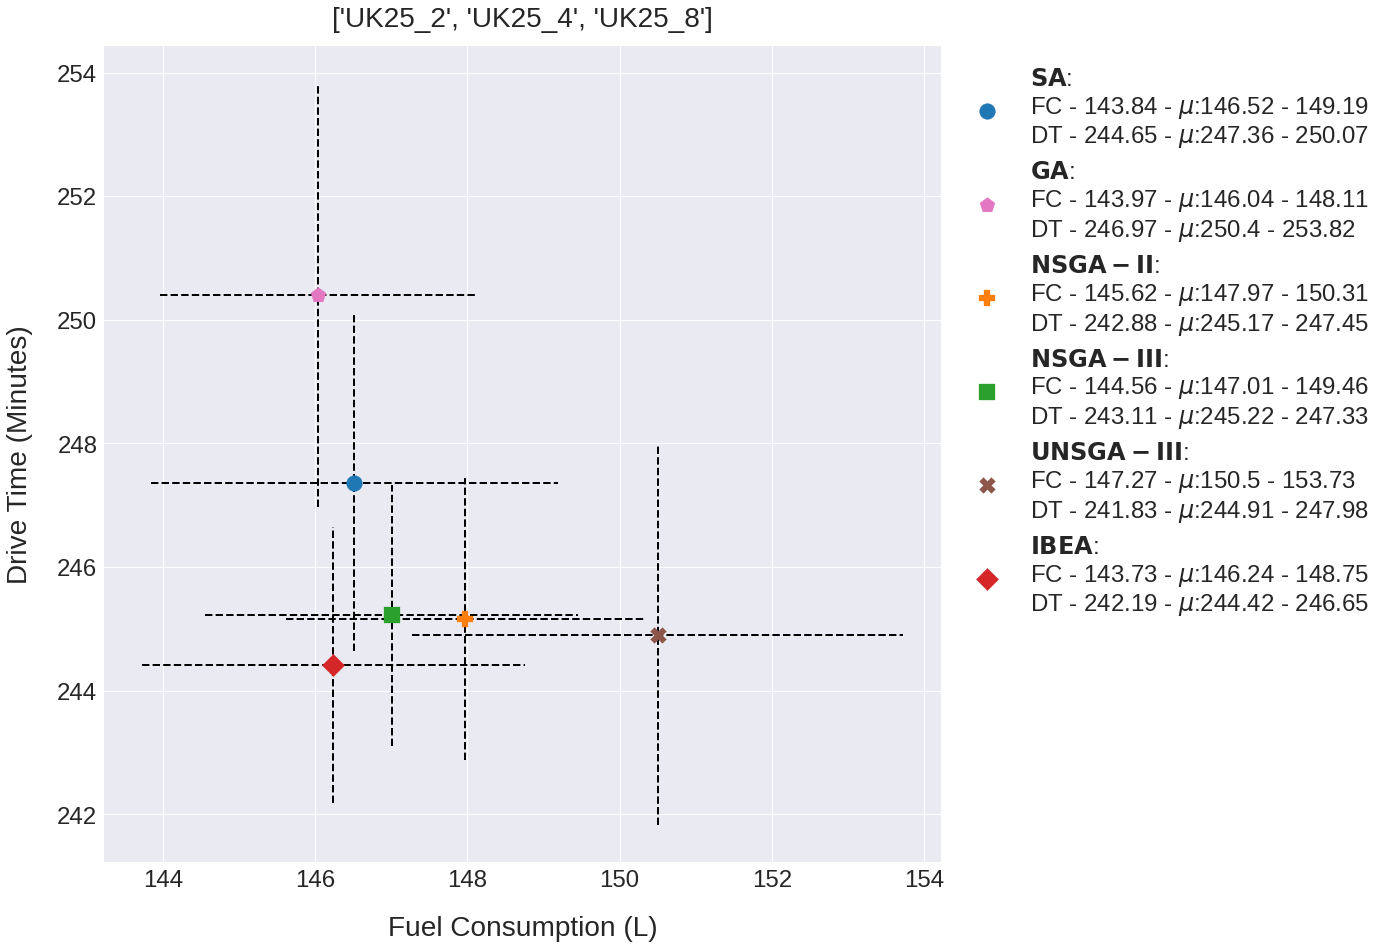

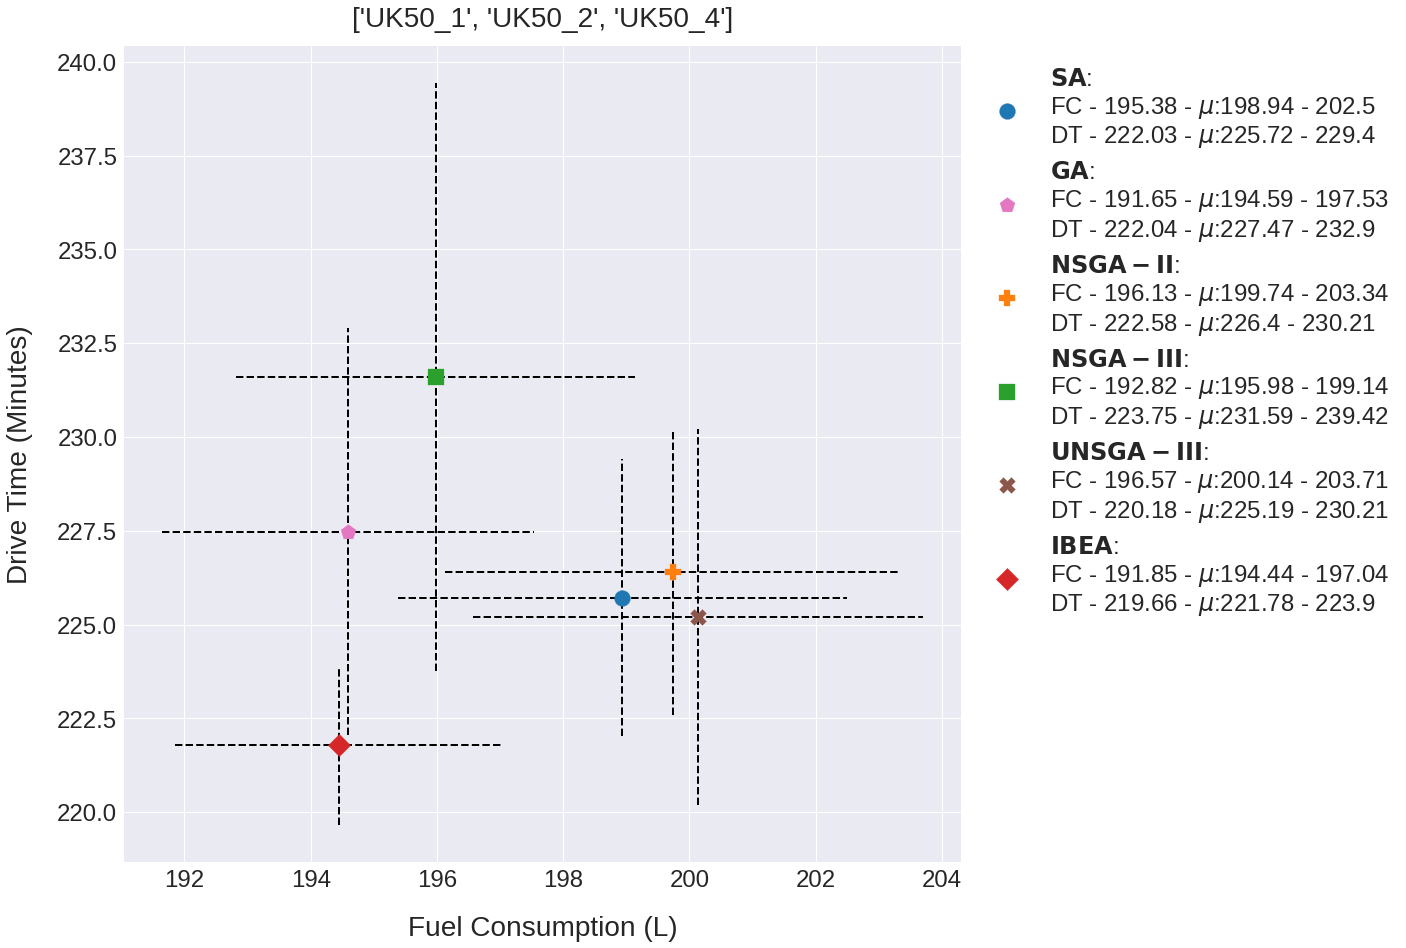

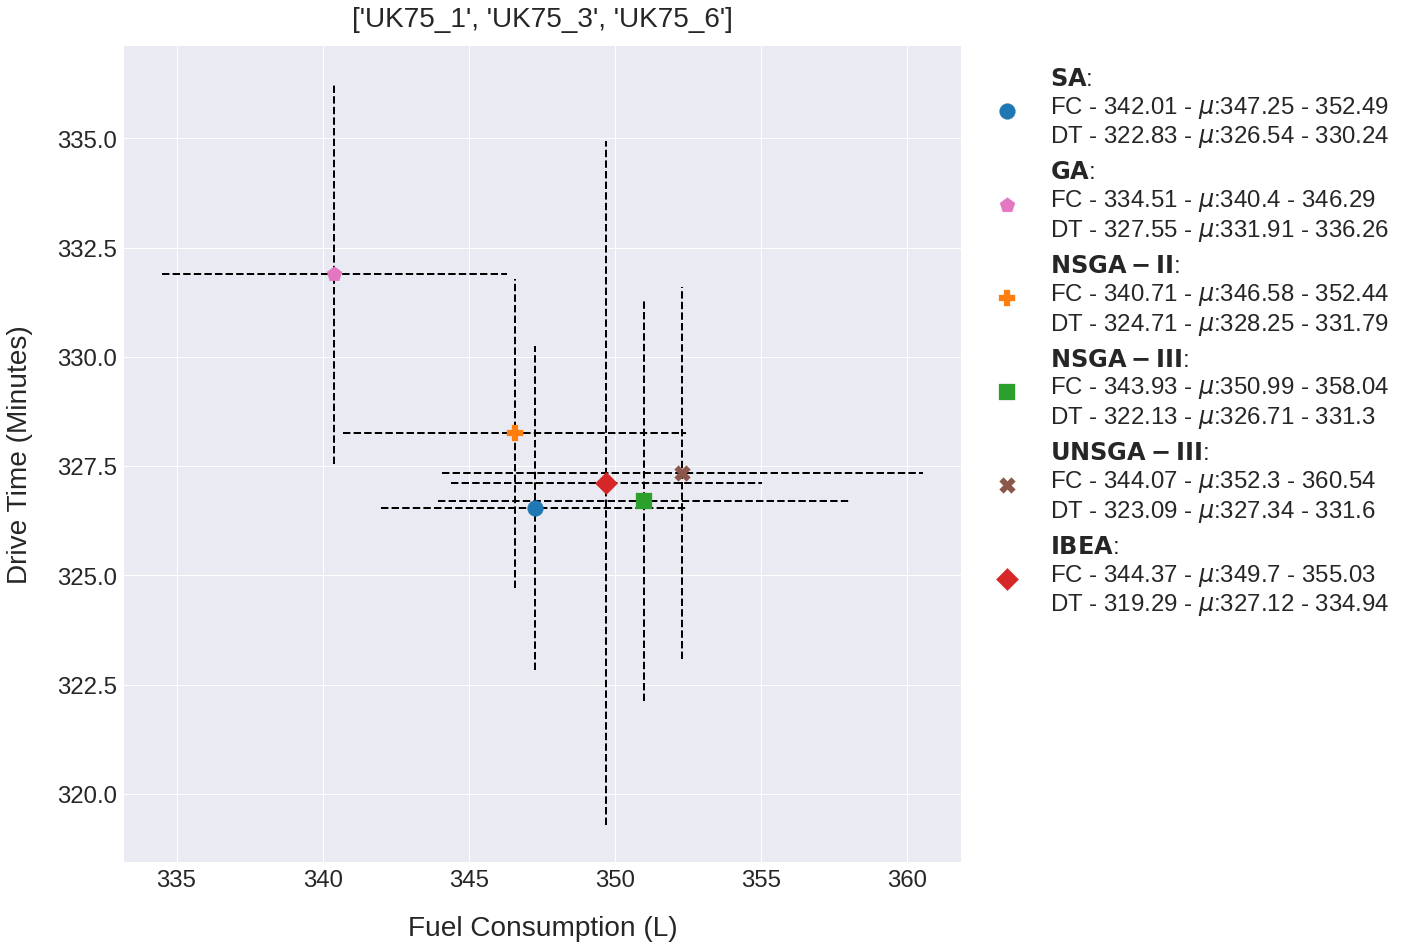

In [50]:
dataset_names =  [["UK25_2", "UK25_4", "UK25_8"],[ "UK50_1", "UK50_2", "UK50_4"],[ "UK75_1","UK75_3","UK75_6"]]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    

    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    #plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()
    


# Plot evaluation limited divided into the three different dataset sizes

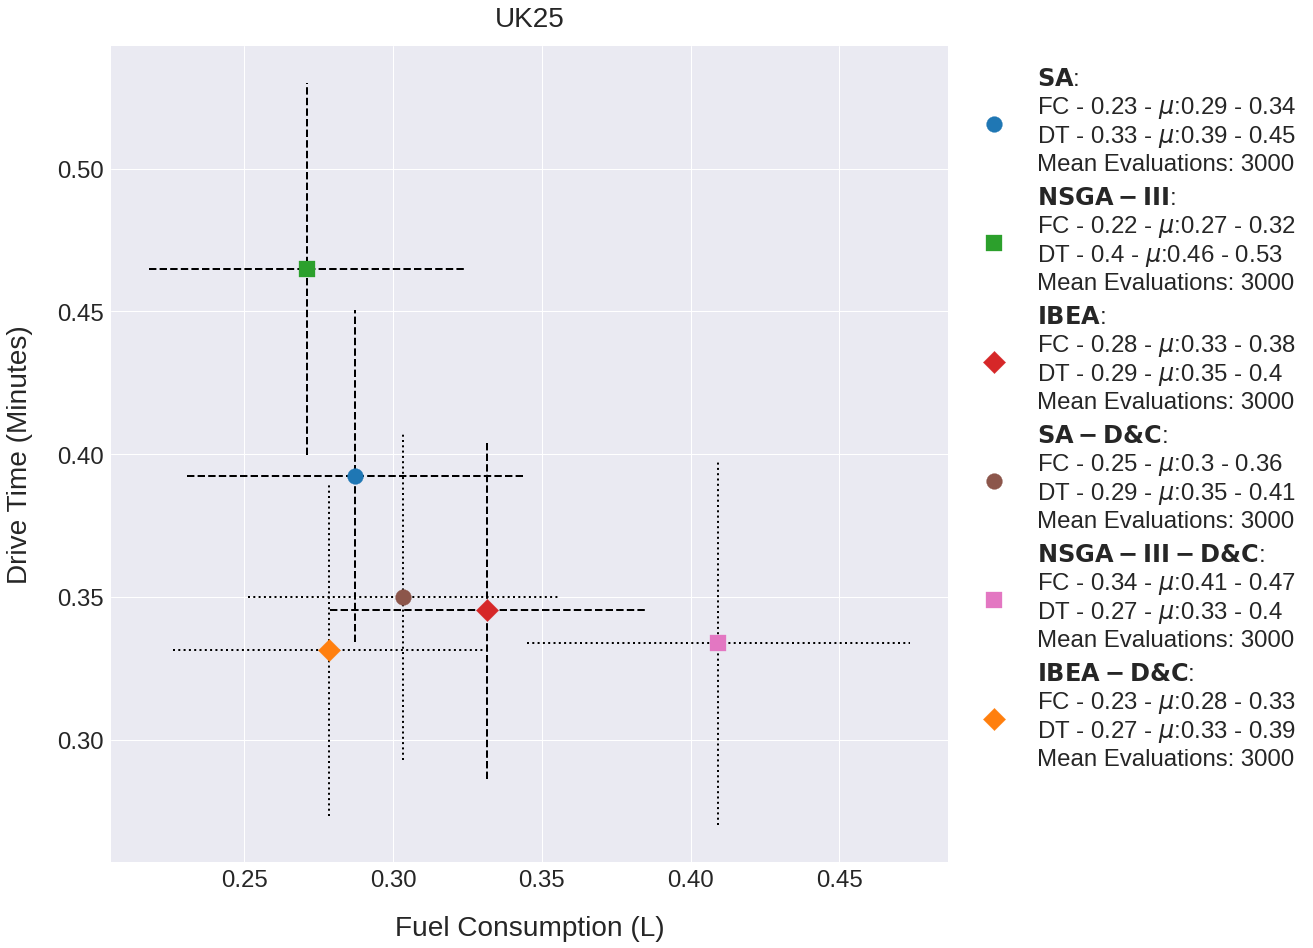

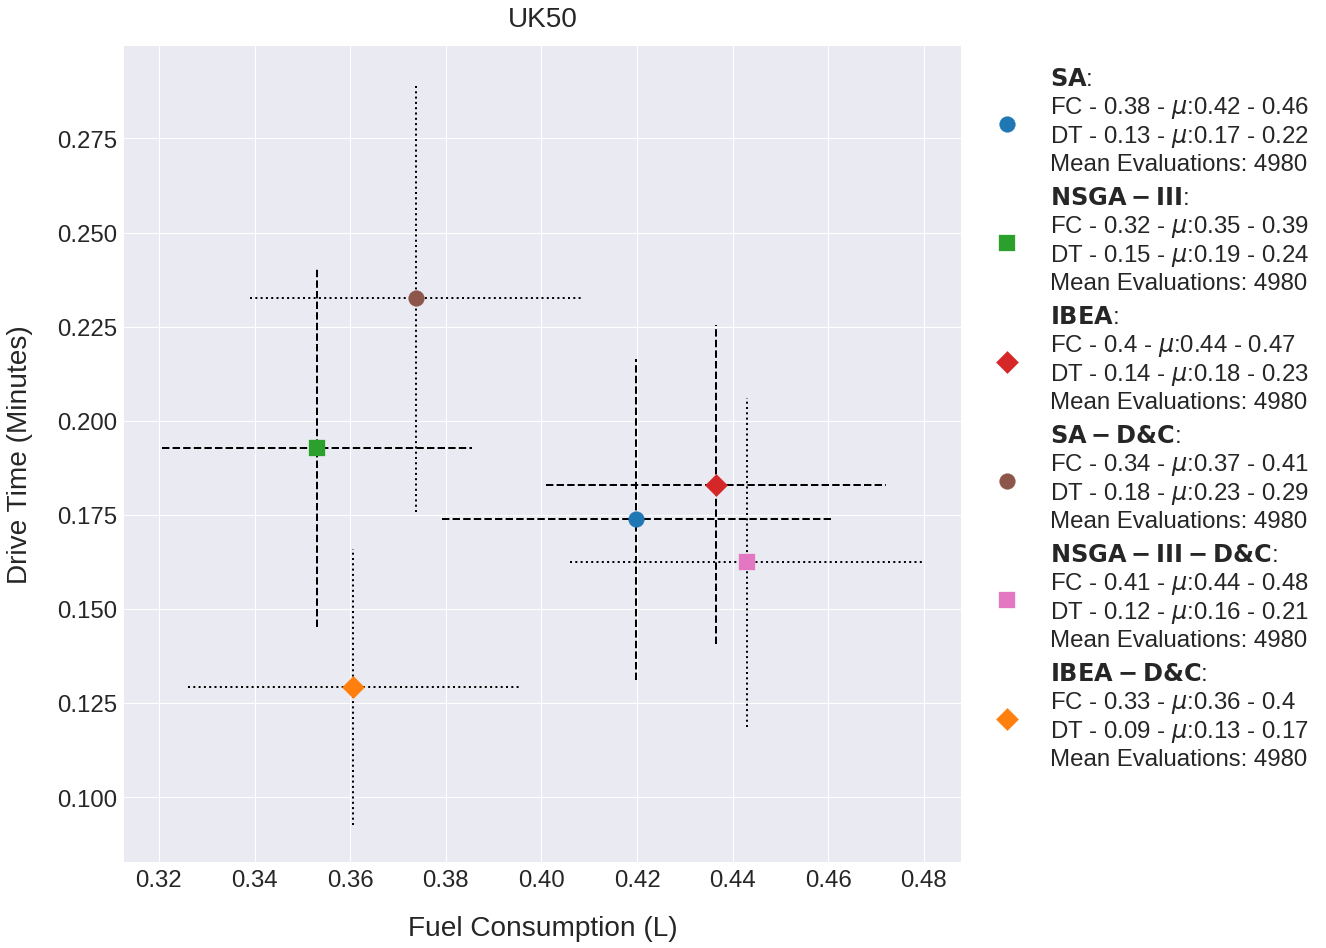

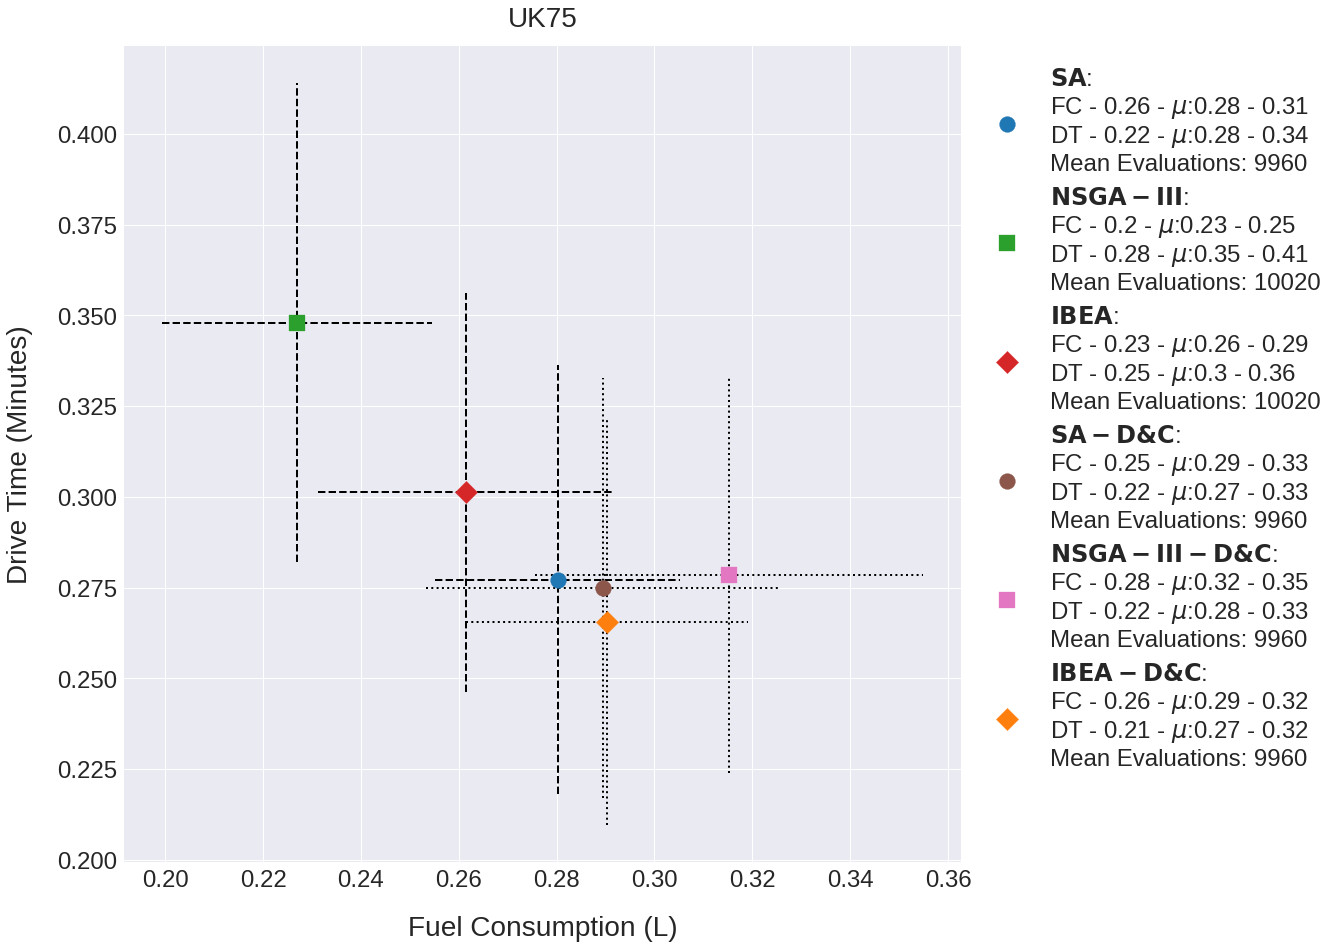

In [101]:

dataset_names =  [["UK25_2", "UK25_4", "UK25_8"],[ "UK50_1", "UK50_2", "UK50_4"],[ "UK75_1","UK75_3","UK75_6"]]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    
    
    
    
    
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    add_minmax_fuel_drivetime_columns(algorithms,dataset)
    
    SA_data_dataset = SA_data_dataset.mean()
    GA_data_dataset = GA_data_dataset.mean()
    NSGA2_data_dataset = NSGA2_data_dataset.mean()
    NSGA3_data_dataset = NSGA3_data_dataset.mean()
    UNSGA3_data_dataset = UNSGA3_data_dataset.mean()
    IBEA_data_dataset = IBEA_data_dataset.mean()
    
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,show_mean_eval=True)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset[0][:4])
    plt.savefig("2d_plot_fuel_drivetime_time_limited_{}.pdf".format(dataset[0][:4]),bbox_inches='tight')
    plt.show()

# Compare Normal vs Pickup and Drop solution (evaluation limited)

In [106]:
import time 
start_time = time.monotonic()
print("SA")

SA_data_evaluation_limited_copy = deepcopy(SA_data_evaluation_limited)
NSGA3_data_evaluation_limited_copy = deepcopy(NSGA3_data_evaluation_limited)
IBEA_data_evaluation_limited_copy = deepcopy(IBEA_data_evaluation_limited)

SA_pickup_and_drop = combine_datasets("SA_pick_and_drop", "parameter_data/pick_and_drop_results/")

print("NSGA3")
NSGA3_pickup_and_drop = combine_datasets("NSGAIII_pick_and_drop", "parameter_data/pick_and_drop_results/")

print("IBEA")
IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/")

add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited_copy,SA_pickup_and_drop,
                                   NSGA3_data_evaluation_limited_copy,NSGA3_pickup_and_drop,
                                   IBEA_data_evaluation_limited_copy,IBEA_pickup_and_drop])

SA_data_evaluation_limited_copy_mean = SA_data_evaluation_limited_copy.mean()
NSGA3_data_evaluation_limited_copy_mean = NSGA3_data_evaluation_limited_copy.mean()
IBEA_data_evaluation_limited_copy_mean = IBEA_data_evaluation_limited_copy.mean()
SA_pickup_and_drop_mean = SA_pickup_and_drop.mean()
NSGA3_pickup_and_drop_mean = NSGA3_pickup_and_drop.mean()
IBEA_pickup_and_drop_mean = IBEA_pickup_and_drop.mean()
print("Time: ", time.monotonic() - start_time)

SA
NSGA3
IBEA
Time:  2.0779301100010343


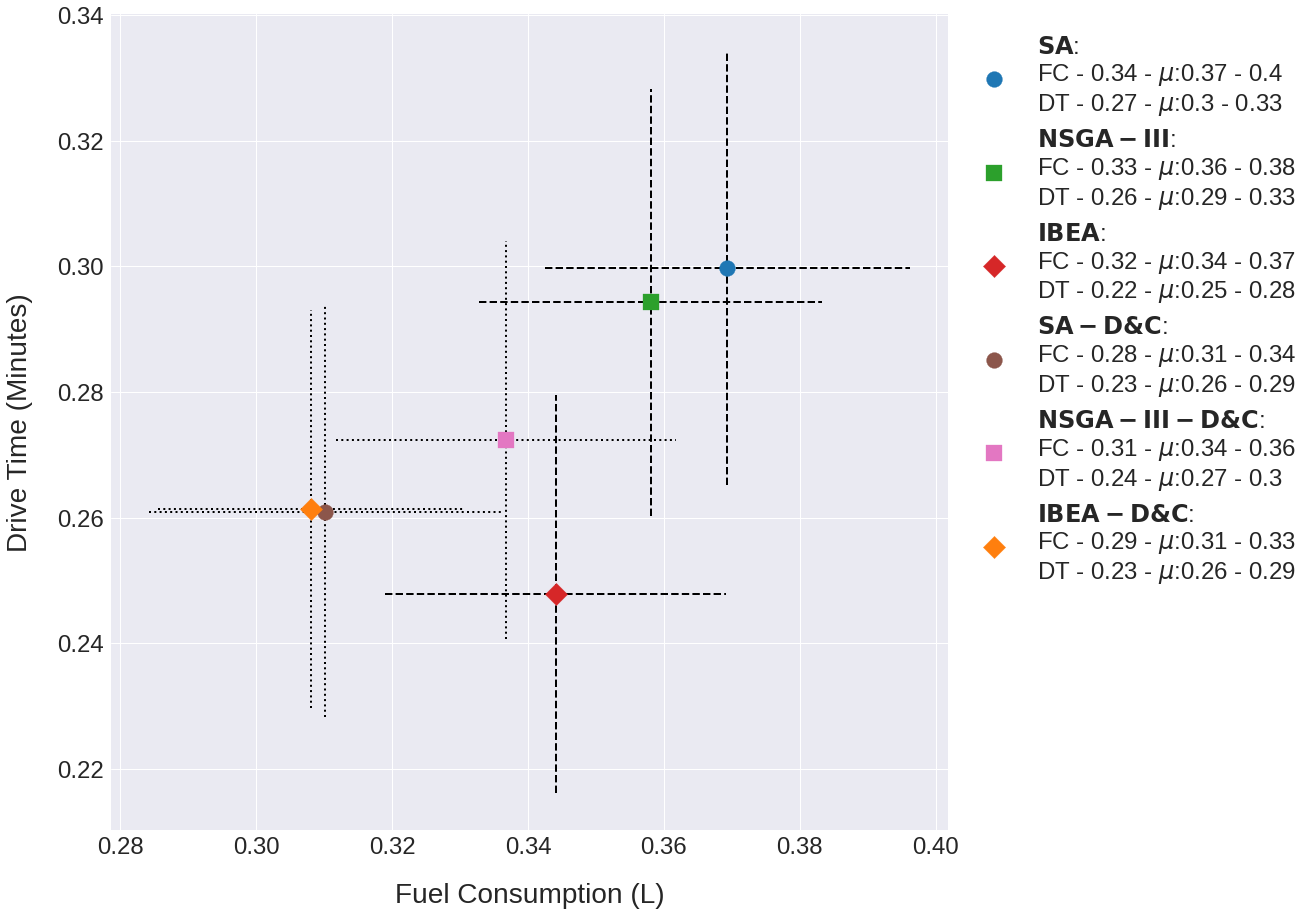

In [103]:
algorithms = [SA_data_evaluation_limited_copy_mean, NSGA3_data_evaluation_limited_copy_mean, IBEA_data_evaluation_limited_copy_mean
              , SA_pickup_and_drop_mean, NSGA3_pickup_and_drop_mean, IBEA_pickup_and_drop_mean]
labels =  ["SA", "NSGA-III","IBEA" ,"SA-D&C", "NSGA-III-D&C","IBEA-D&C" ]
fig, ax = plot_2d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_pickup_and_drop_{}.pdf".format("combined"),bbox_inches='tight')
#plt.tight_layout(pad=2)
plt.show()

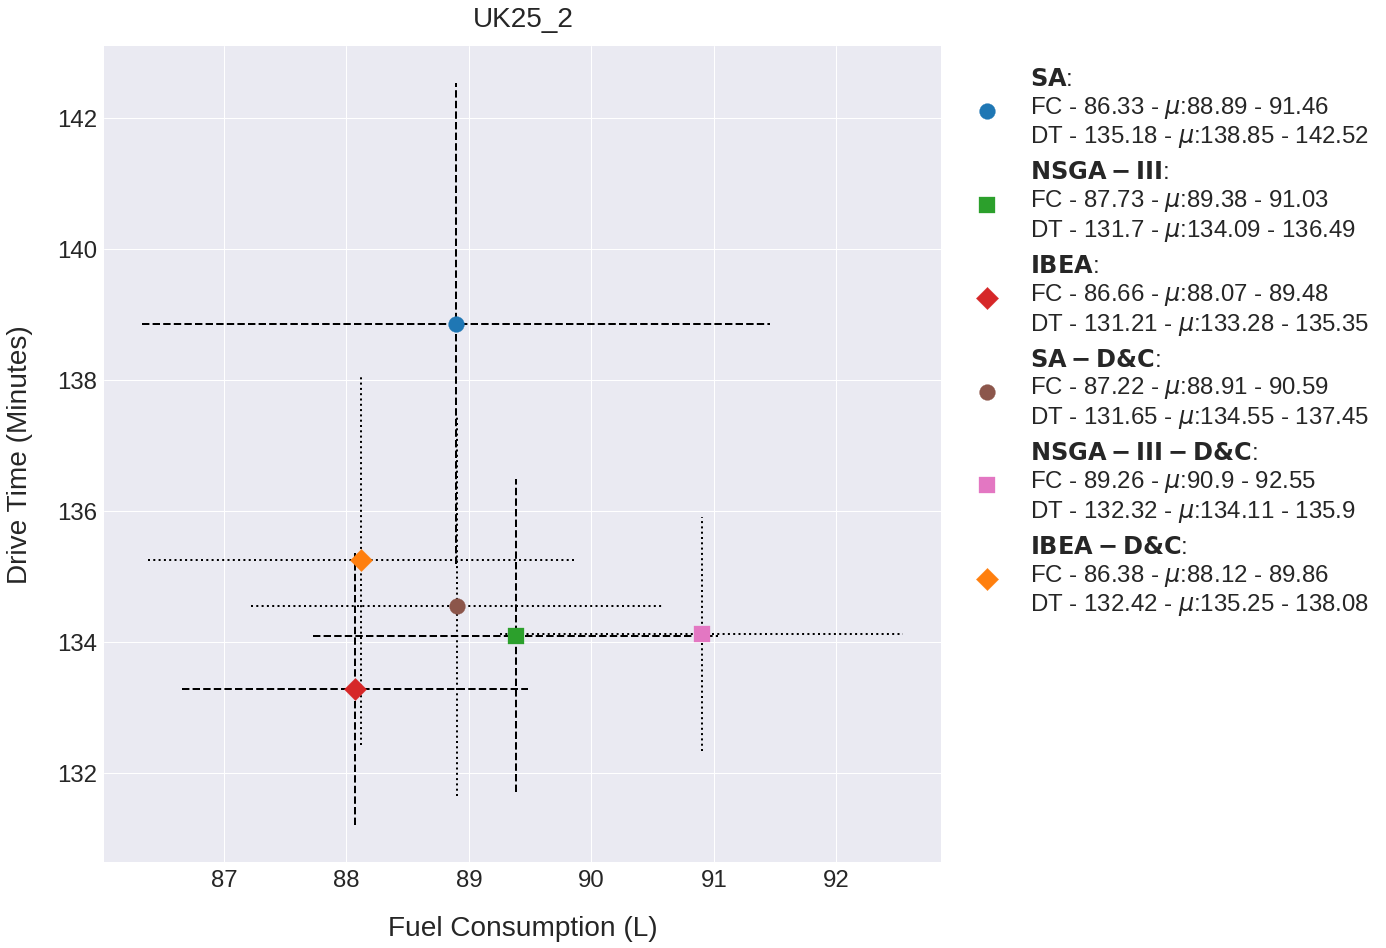

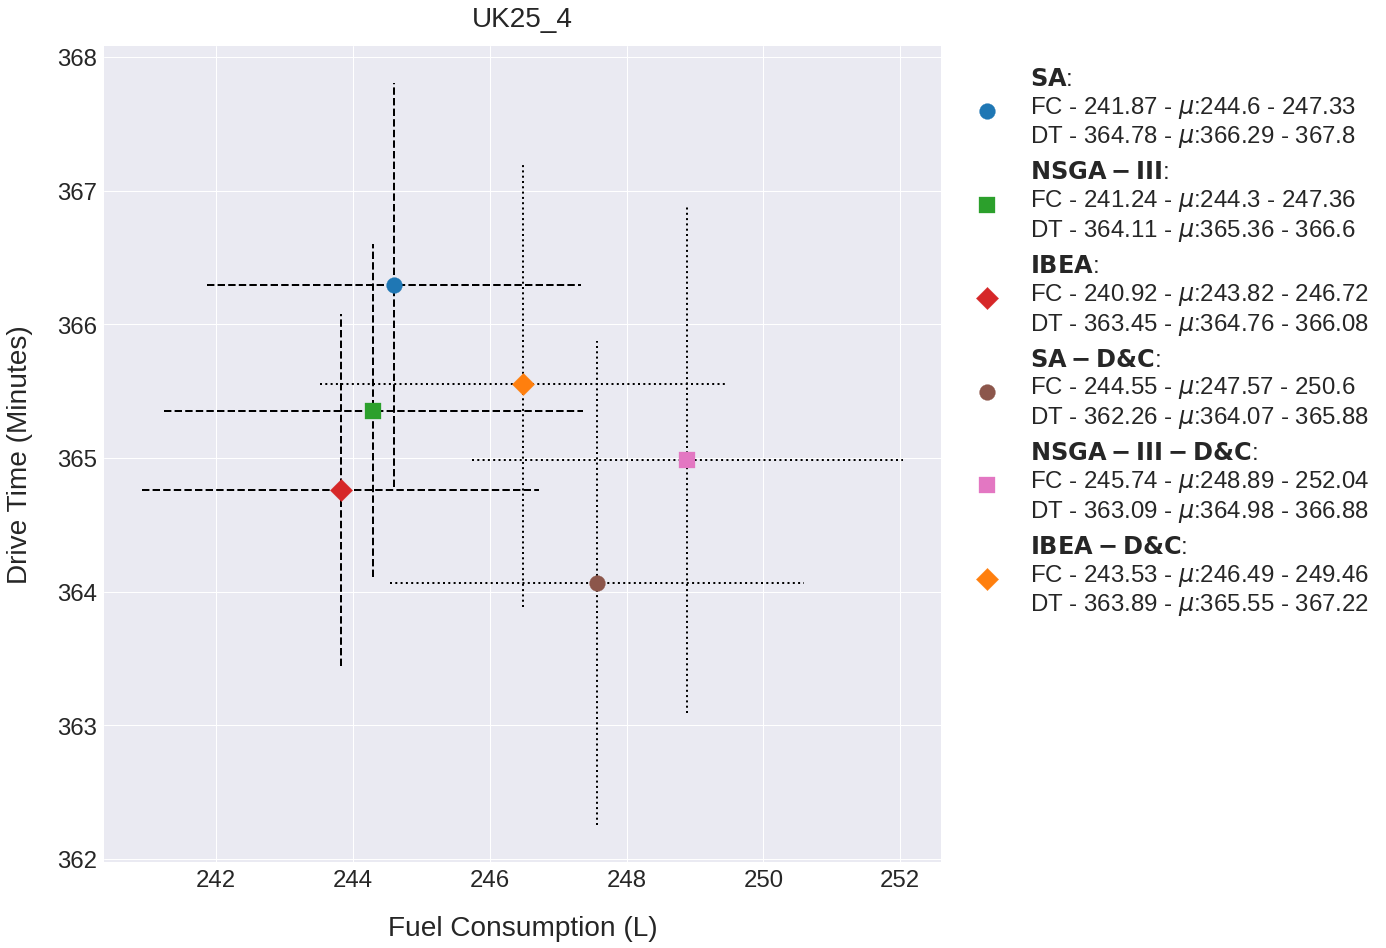

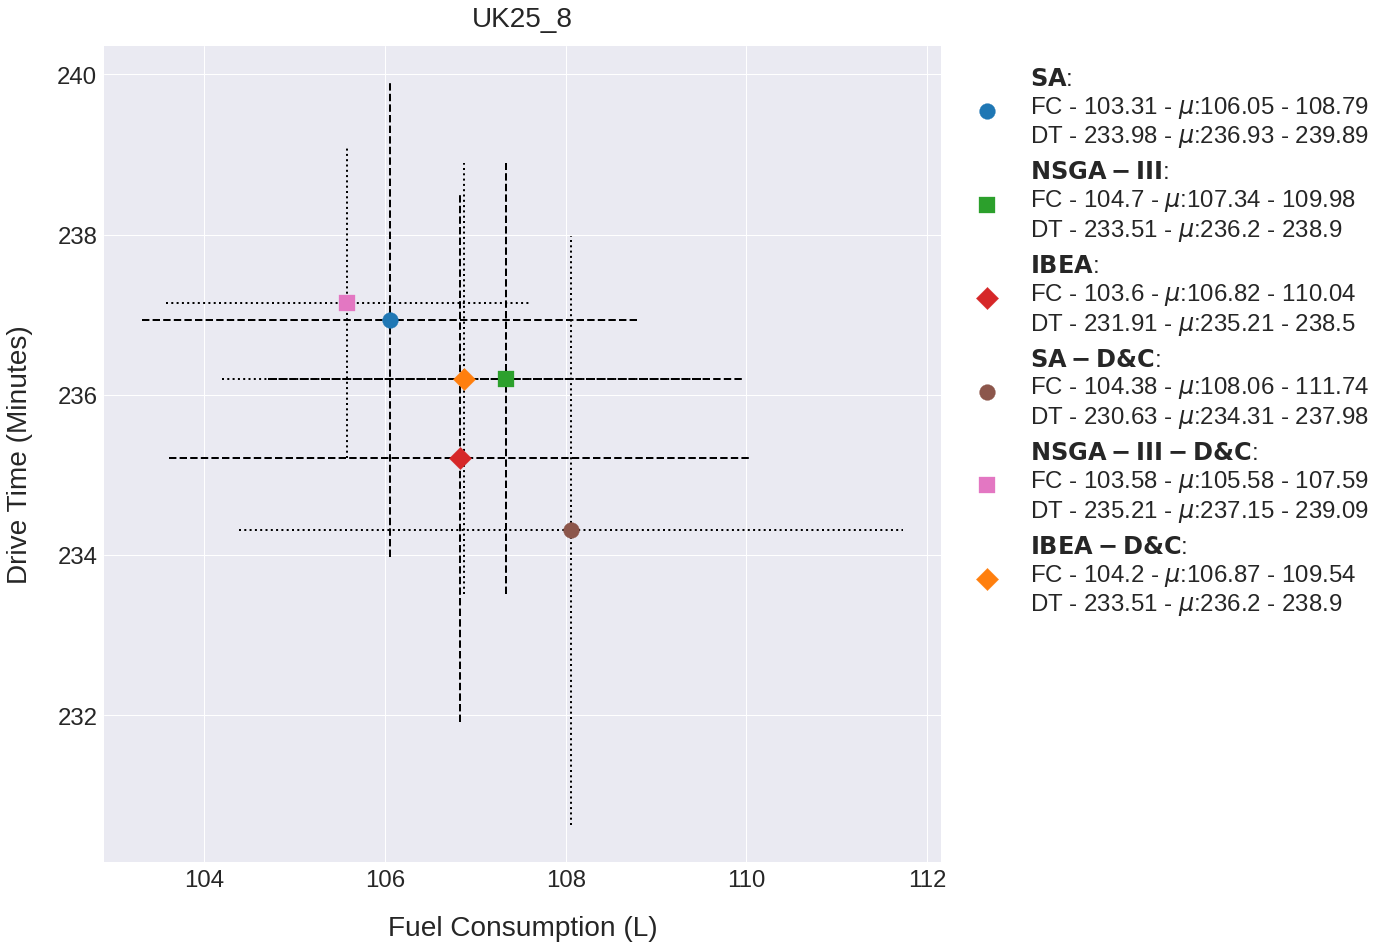

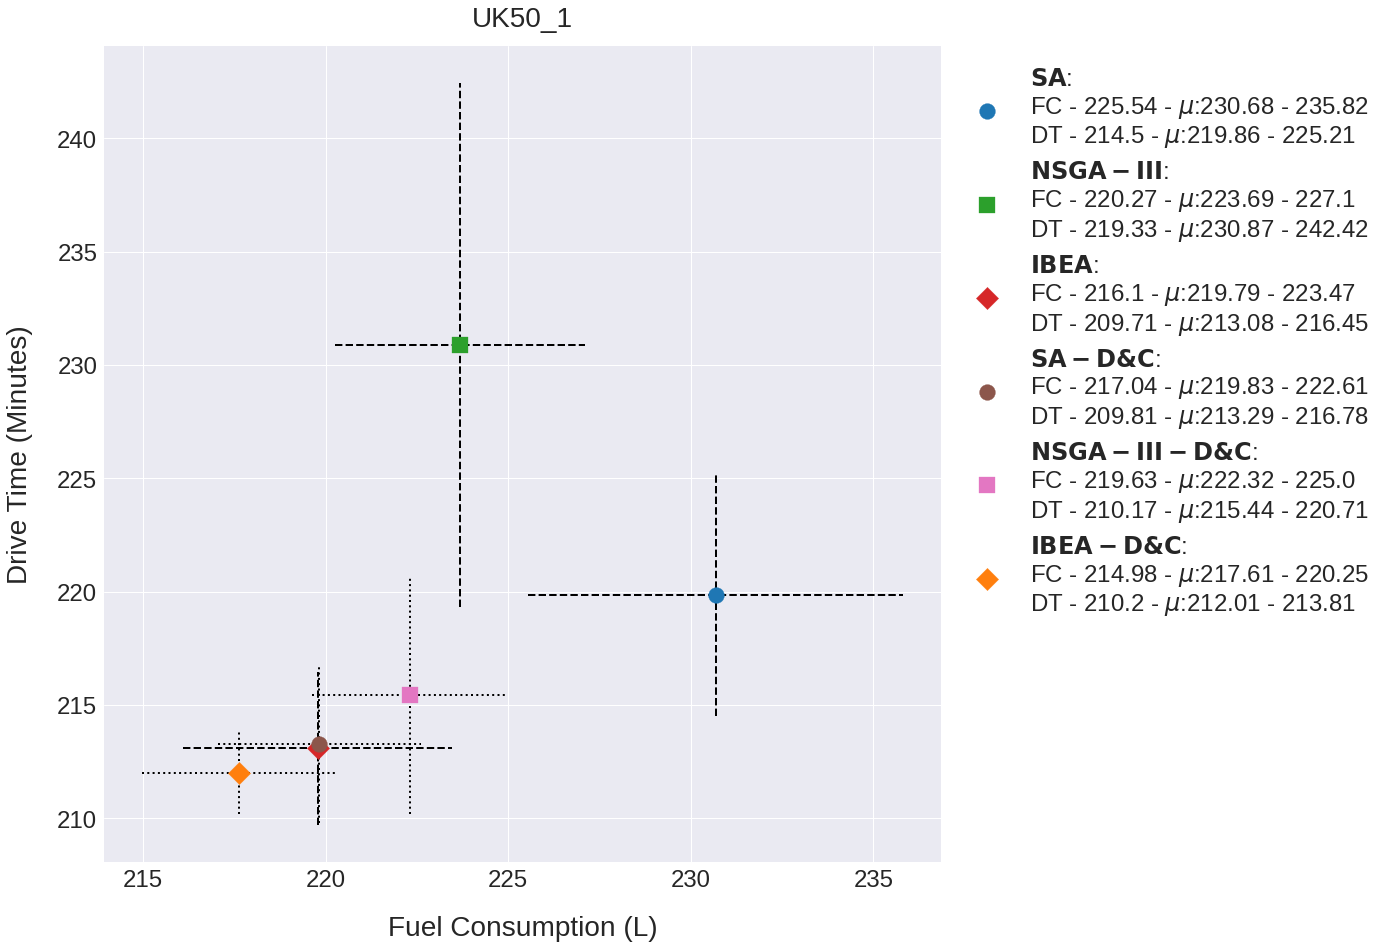

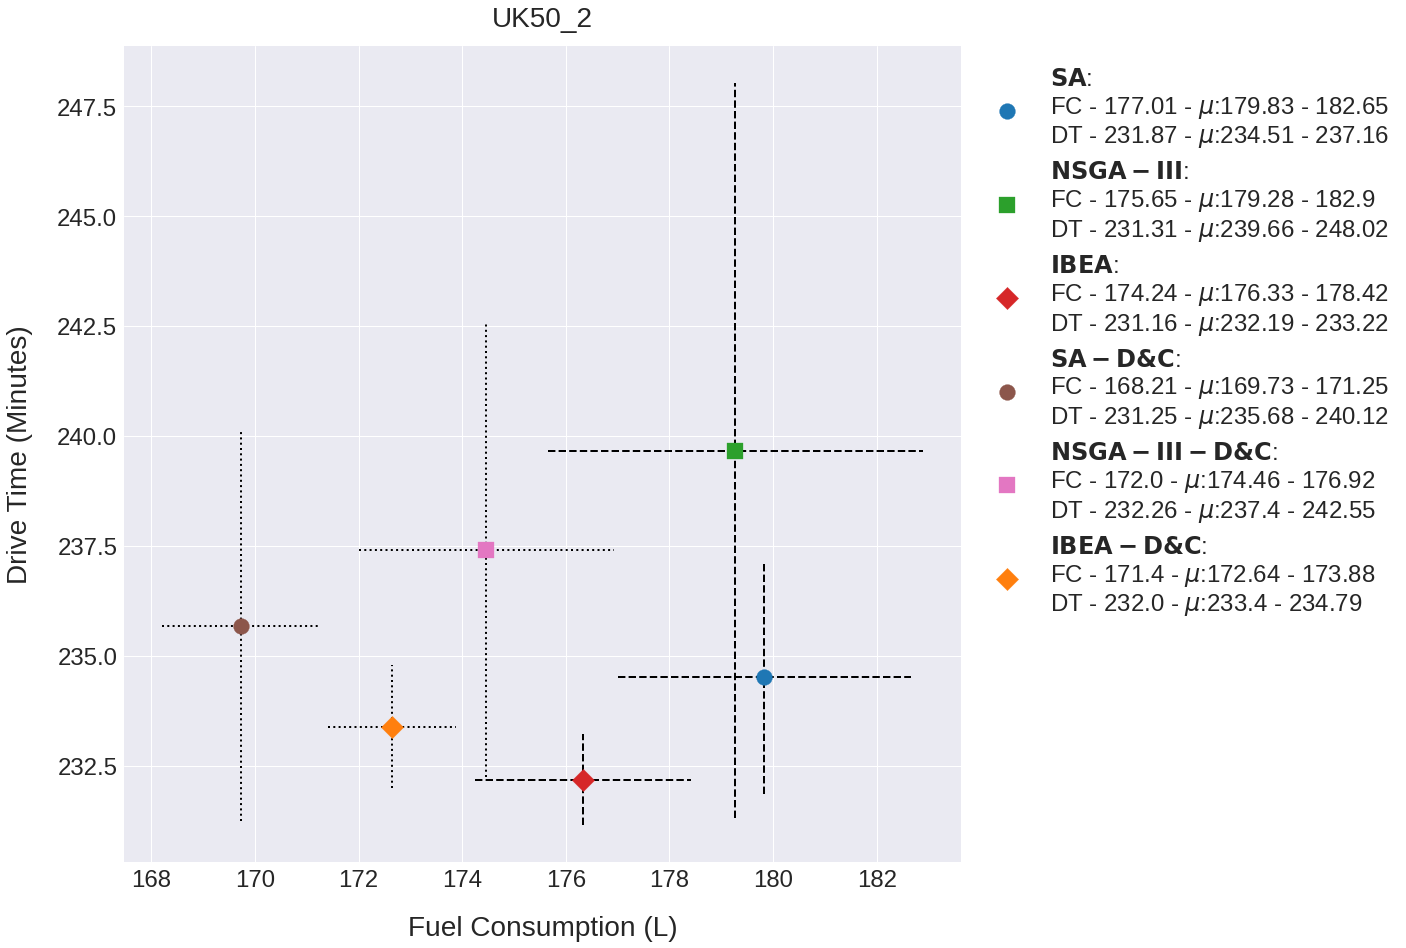

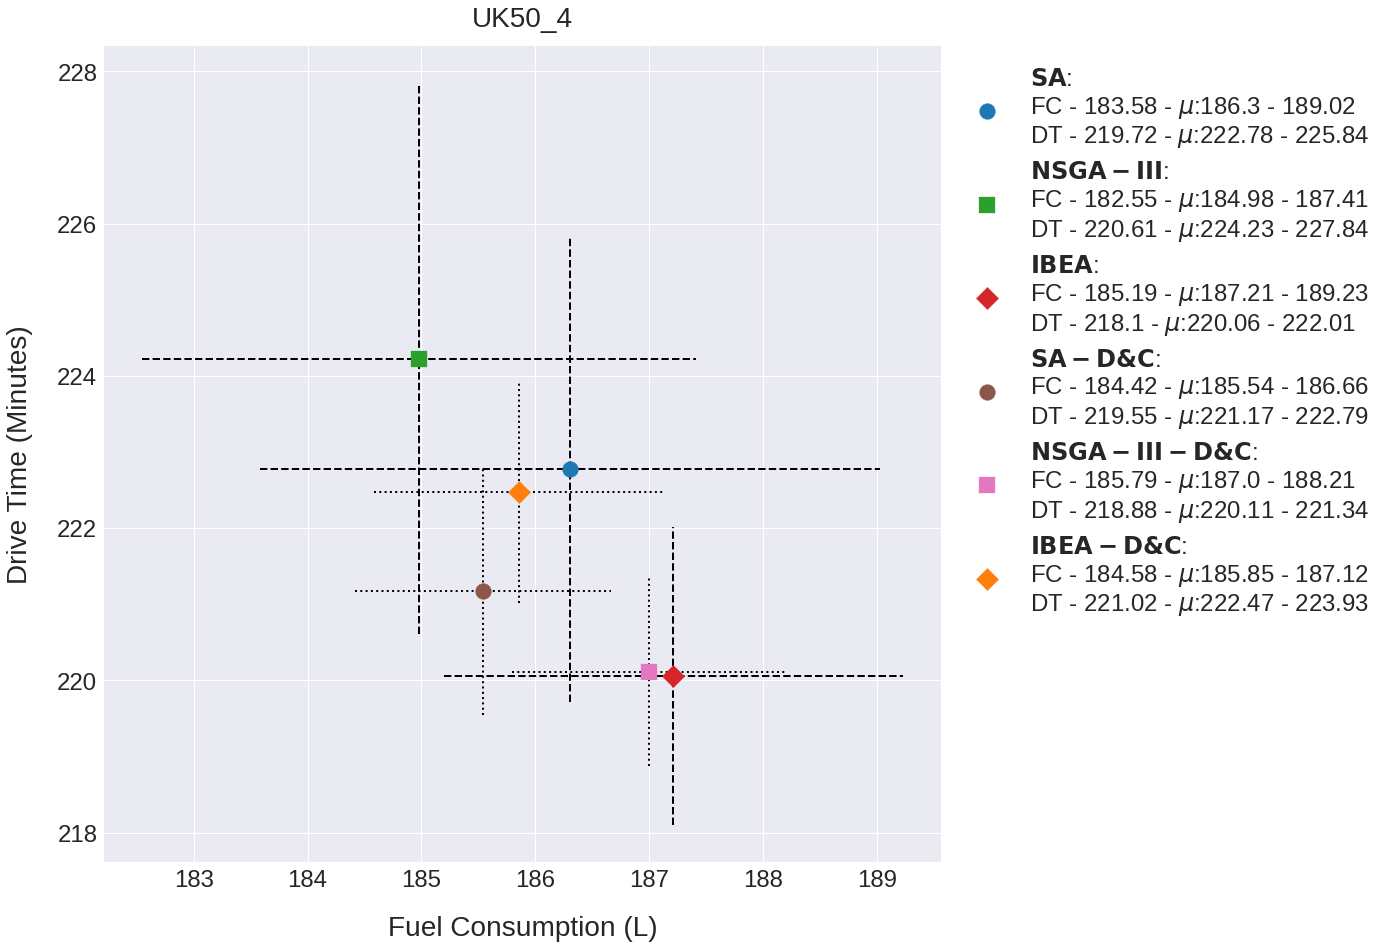

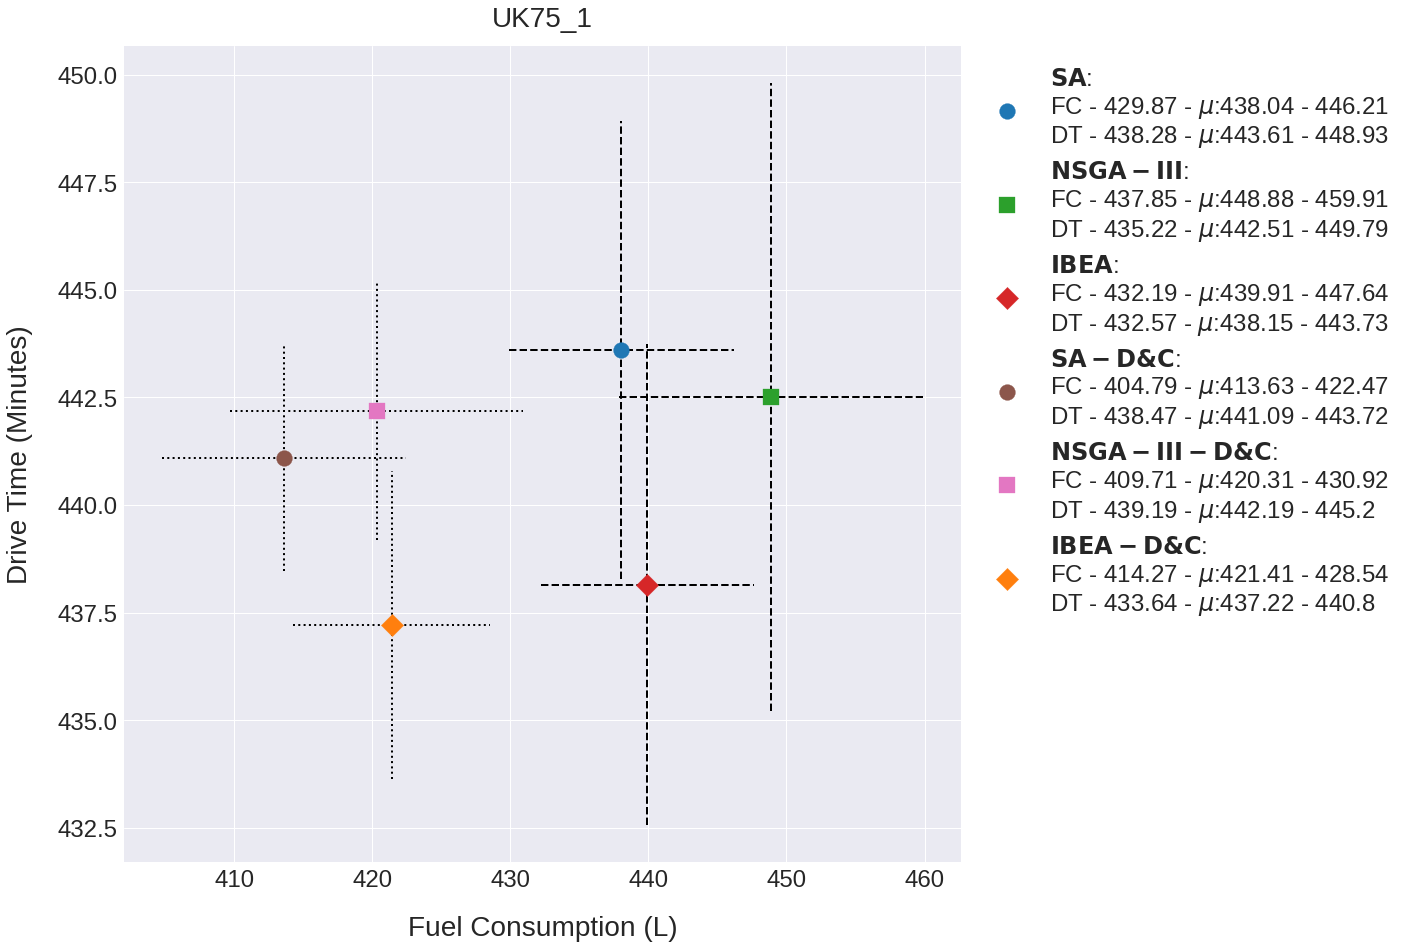

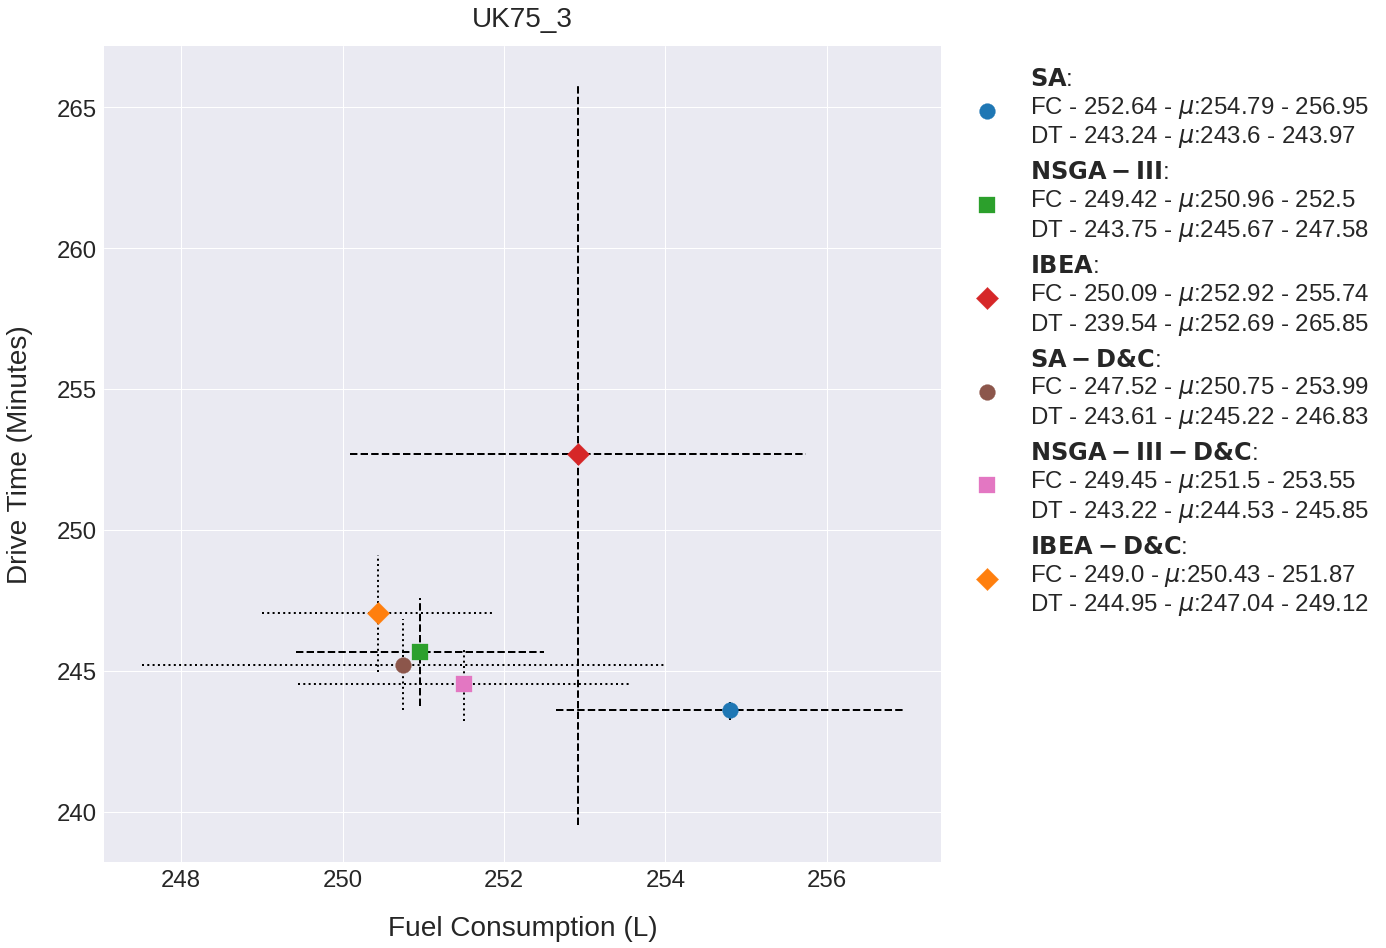

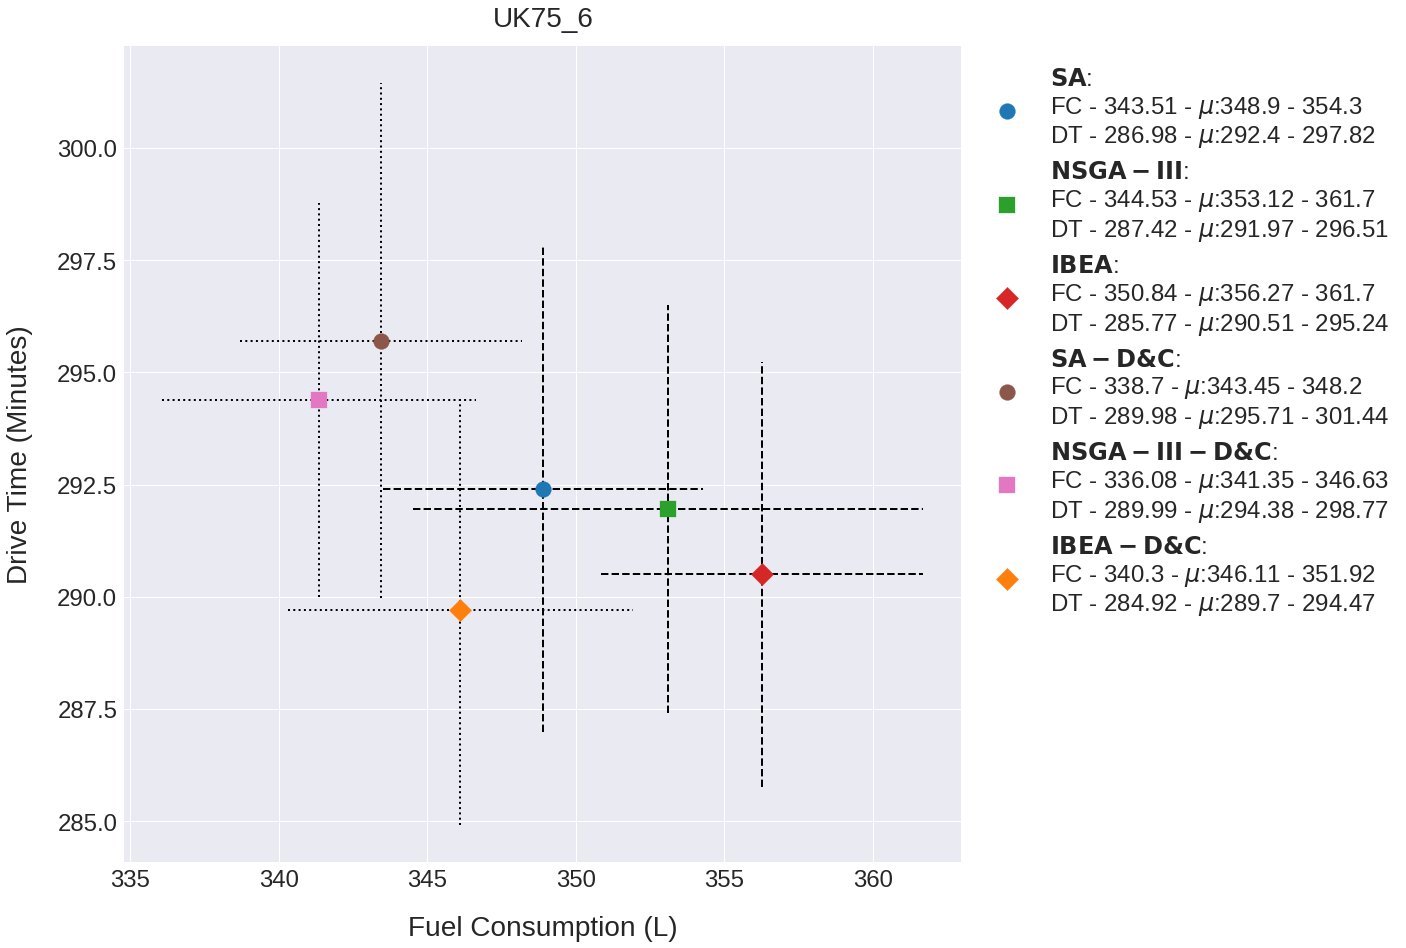

In [102]:
for dataset in ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]:
    SA_data_evaluation_limited_unique = combine_datasets("SA", "parameter_data/reruns/", dataset)

    IBEA_data_evaluation_limited_unique = combine_datasets("IBEA", "parameter_data/reruns_L1/", dataset)
    NSGA3_data_evaluation_limited_unique = combine_datasets("NSGA3", "parameter_data/reruns_L1/", dataset)
    
    SA_pickup_and_drop = combine_datasets("SA_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    NSGA3_pickup_and_drop = combine_datasets("NSGAIII_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    algorithms = [SA_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique,IBEA_data_evaluation_limited_unique,SA_pickup_and_drop,NSGA3_pickup_and_drop,IBEA_pickup_and_drop ]
    add_minmax_fuel_drivetime_columns(algorithms)
    
    SA_data_evaluation_limited_unique = SA_data_evaluation_limited_unique.mean()
    IBEA_data_evaluation_limited_unique = IBEA_data_evaluation_limited_unique.mean()
    NSGA3_data_evaluation_limited_unique = NSGA3_data_evaluation_limited_unique.mean()
    
    SA_pickup_and_drop = SA_pickup_and_drop.mean()
    IBEA_pickup_and_drop = IBEA_pickup_and_drop.mean()
    NSGA3_pickup_and_drop = NSGA3_pickup_and_drop.mean()
    algorithms = [SA_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique,IBEA_data_evaluation_limited_unique,SA_pickup_and_drop,NSGA3_pickup_and_drop,IBEA_pickup_and_drop ]
    
    
    
    labels = ["SA", "NSGA-III","IBEA" ,"SA-D&C", "NSGA-III-D&C","IBEA-D&C" ]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    #plt.tight_layout(pad=2)
    plt.title(dataset)#[0][:4])
    plt.savefig("2d_plot_fuel_drivetime_pickup_and_drop_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()

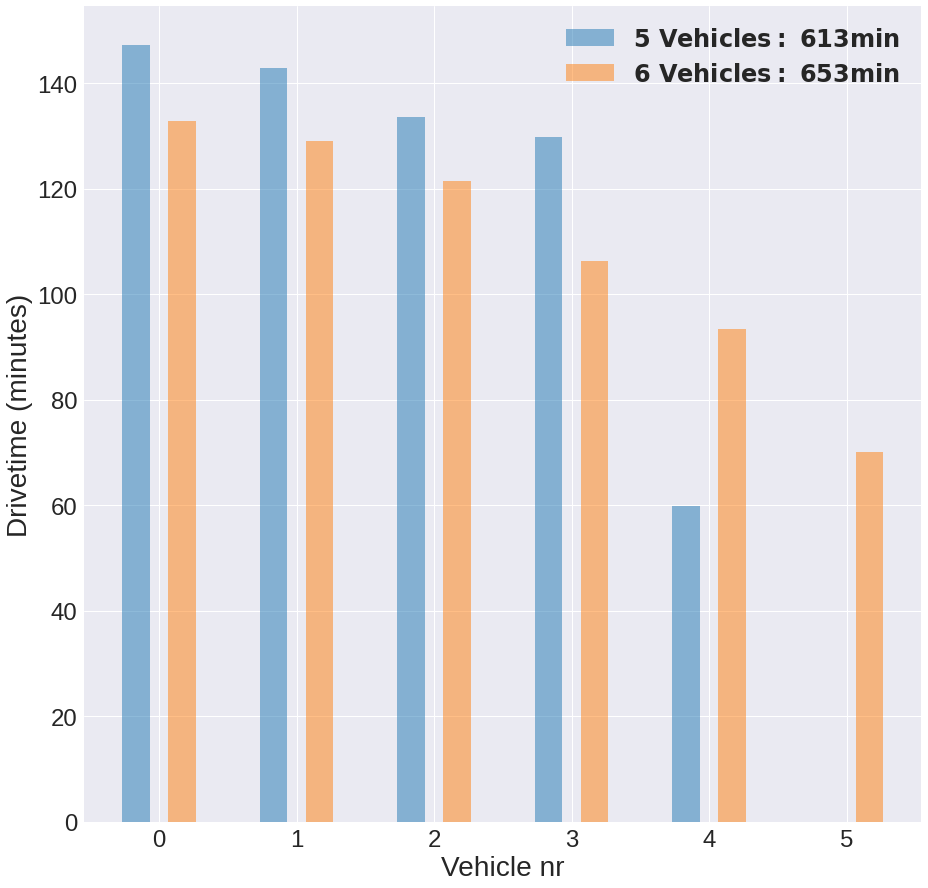

In [126]:

data_name = "UK25_2"

IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", data_name)
plot_vehicle_drivetimes(IBEA_pickup_and_drop,data_name)

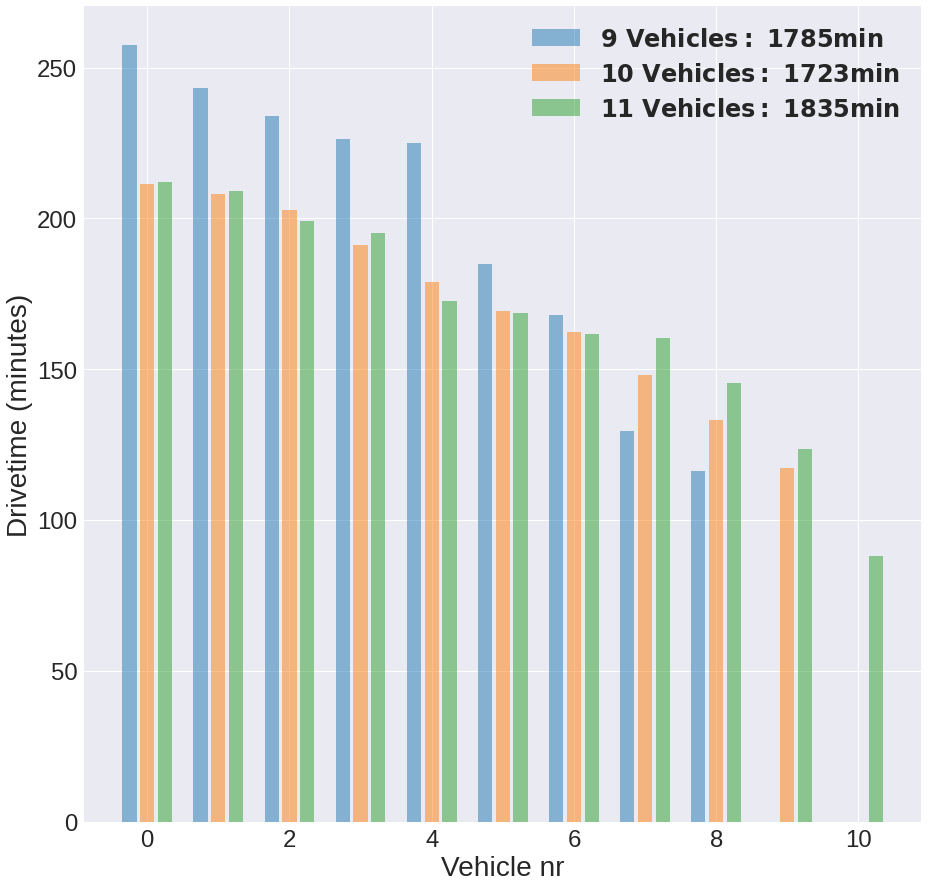

In [125]:
plot_vehicle_drivetimes(IBEA_data_evaluation_limited,"UK50_1")

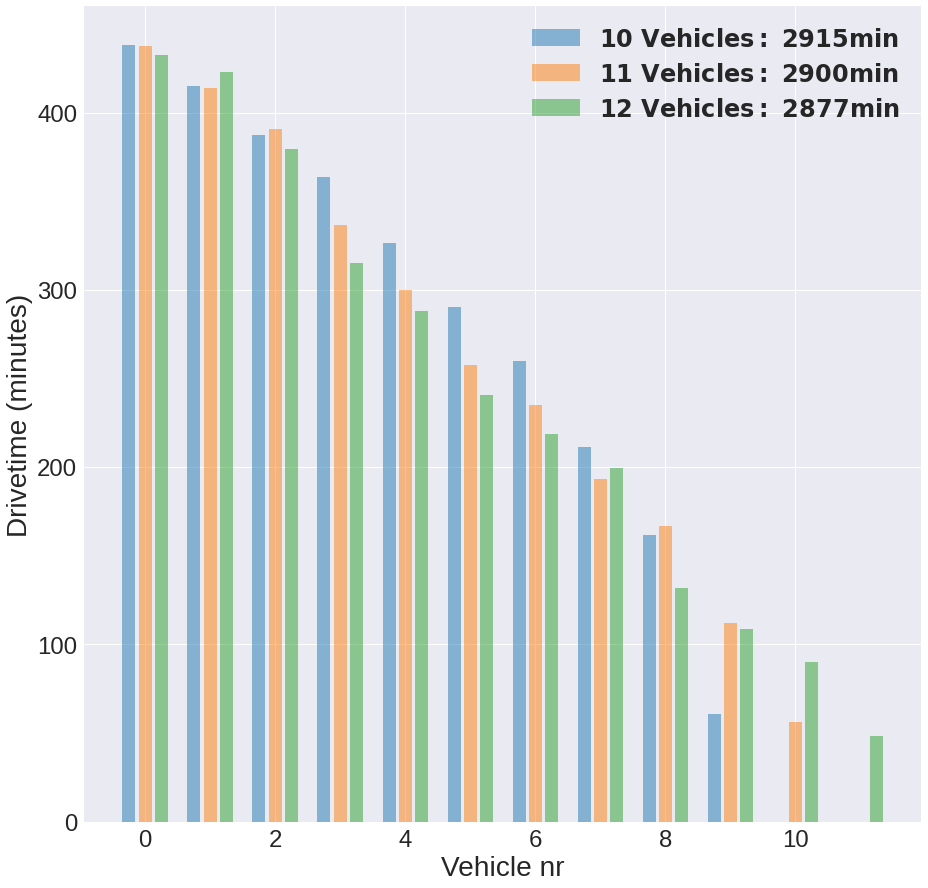

In [27]:

data_name = "UK75_1"

IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", data_name)
plot_vehicle_drivetimes(IBEA_pickup_and_drop,data_name)

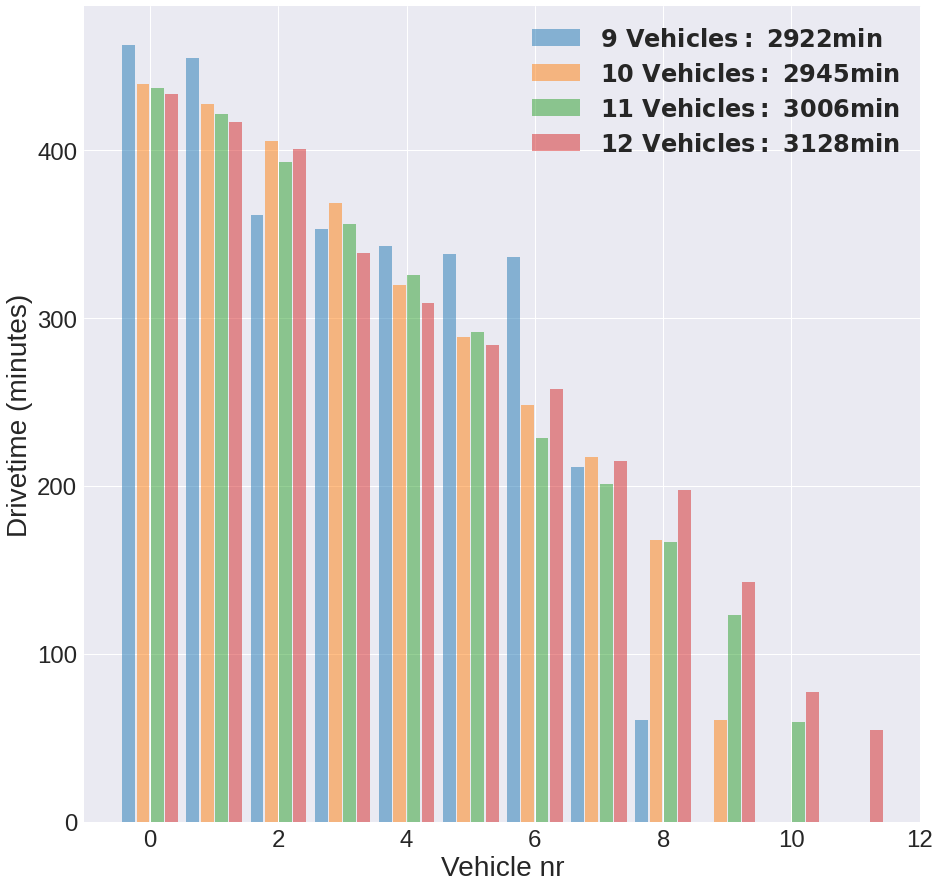

In [127]:
plot_vehicle_drivetimes(IBEA_data_evaluation_limited,"UK75_1")

In [29]:
dataset_names = ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]

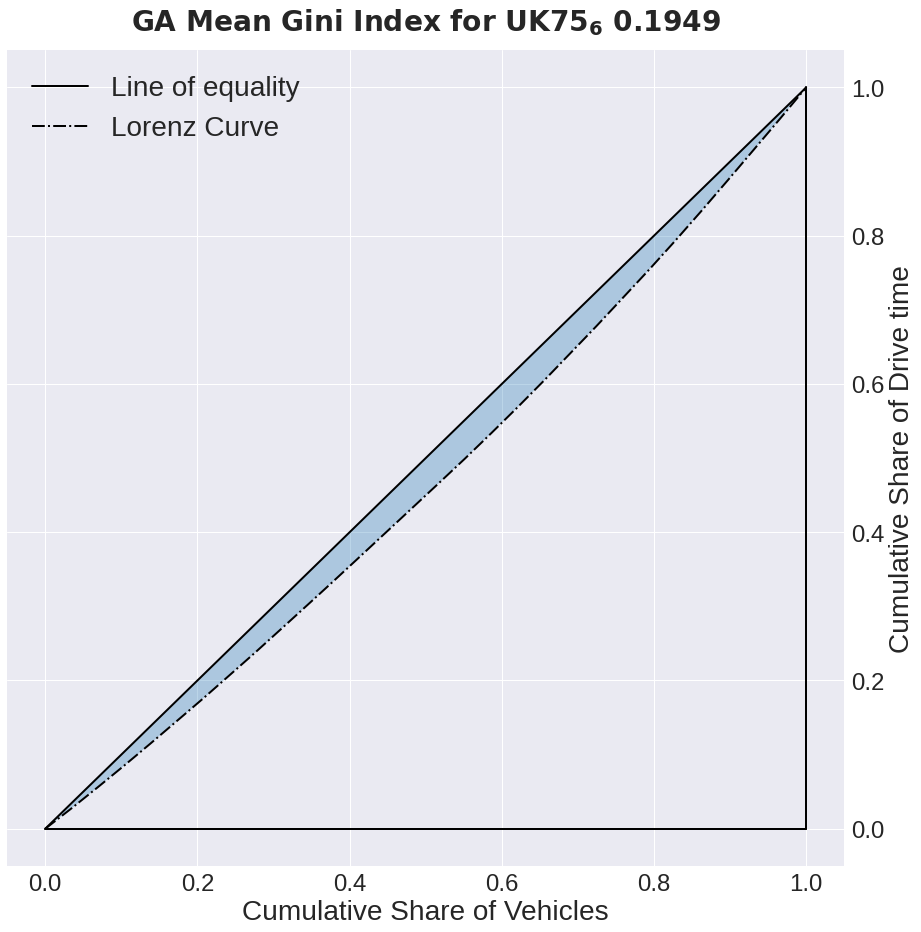

In [114]:
plot_gini_distribution(IBEA_data_evaluation_limited,"GA","UK75_6")   

In [216]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
correlations = []
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")

    algorithms_df = pd.concat([SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset])
    correlations.append([dataset,np.round(algorithms_df[["longest_route_time_final","fuel_consumption_final"]].reset_index(drop=True).corr().fuel_consumption_final[0],4)])

algorithms_df = pd.concat([SA_data_evaluation_limited, GA_data_evaluation_limited, NSGA2_data_evaluation_limited, NSGA3_data_evaluation_limited, UNSGA3_data_evaluation_limited, IBEA_data_evaluation_limited])
correlations.append(["Overall",np.round(algorithms_df[["longest_route_time_final","fuel_consumption_final"]].reset_index(drop=True).corr().fuel_consumption_final[0],4)])


gini_drivetime_corr_df = pd.DataFrame(correlations,columns=["Dataset","Correlation"])
print(gini_drivetime_corr_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Dataset &  Correlation \\
\midrule
 UK25\_2 &      -0.5322 \\
 UK25\_4 &      -0.4262 \\
 UK25\_8 &      -0.9286 \\
 UK50\_1 &      -0.1088 \\
 UK50\_2 &       0.3167 \\
 UK50\_4 &      -0.7869 \\
 UK75\_1 &      -0.2572 \\
 UK75\_3 &       0.2904 \\
 UK75\_6 &      -0.3964 \\
Overall &       0.8202 \\
\bottomrule
\end{tabular}



In [217]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
correlations = []
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")

    algorithms_df = pd.concat([SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset])
    correlations.append([dataset,np.round(algorithms_df[["fuel_consumption_final","gini_index"]].reset_index(drop=True).corr().gini_index[0],4)])

algorithms_df = pd.concat([SA_data_evaluation_limited, GA_data_evaluation_limited, NSGA2_data_evaluation_limited, NSGA3_data_evaluation_limited, UNSGA3_data_evaluation_limited, IBEA_data_evaluation_limited])
correlations.append(["Overall",np.round(algorithms_df[["fuel_consumption_final","gini_index"]].reset_index(drop=True).corr().gini_index[0],4)])


gini_drivetime_corr_df = pd.DataFrame(correlations,columns=["Dataset","Correlation"])
print(gini_drivetime_corr_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Dataset &  Correlation \\
\midrule
 UK25\_2 &      -0.4638 \\
 UK25\_4 &       0.1342 \\
 UK25\_8 &      -0.9034 \\
 UK50\_1 &      -0.0594 \\
 UK50\_2 &      -0.0200 \\
 UK50\_4 &      -0.5263 \\
 UK75\_1 &      -0.3378 \\
 UK75\_3 &       0.0955 \\
 UK75\_6 &      -0.2285 \\
Overall &       0.4367 \\
\bottomrule
\end{tabular}



In [10]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all")
    
    correlations["SA"].append(np.round(np.median(get_gini_coefficients(SA_data_dataset,dataset)),4))
    correlations["GA"].append(np.round(np.median(get_gini_coefficients(GA_data_dataset,dataset)),4))
    correlations["NSGA-II"].append(np.round(np.median(get_gini_coefficients(NSGA2_data_dataset,dataset)),4))
    correlations["NSGA-III"].append(np.round(np.median(get_gini_coefficients(NSGA3_data_dataset,dataset)),4))
    correlations["UNSGA-III"].append(np.round(np.median(get_gini_coefficients(UNSGA3_data_dataset,dataset)),4))
    correlations["IBEA"].append(np.round(np.median(get_gini_coefficients(IBEA_data_dataset,dataset)),4))
    
# correlations["SA"].append(np.round(np.median(get_gini_coefficients(SA_data_time_limited)),4))
# correlations["GA"].append(np.round(np.median(get_gini_coefficients(GA_data_time_limited)),4))
# correlations["NSGA-II"].append(np.round(np.median(get_gini_coefficients(NSGA2_data_time_limited)),4))
# correlations["NSGA-III"].append(np.round(np.median(get_gini_coefficients(NSGA3_data_time_limited)),4))
# correlations["UNSGA-III"].append(np.round(np.median(get_gini_coefficients(UNSGA3_data_time_limited)),4))
# correlations["IBEA"].append(np.round(np.median(get_gini_coefficients(IBEA_data_time_limited)),4))    
    

gini_index_df = pd.DataFrame(correlations,index=dataset_names)

print(gini_index_df.to_latex(column_format="lcccccc"))

\begin{tabular}{lcccccc}
\toprule
{} &      SA &      GA &  NSGA-II &  NSGA-III &  UNSGA-III &    IBEA \\
\midrule
UK25\_2 &  0.0995 &  0.0930 &   0.0984 &    0.0853 &     0.1009 &  0.1132 \\
UK25\_4 &  0.2956 &  0.3081 &   0.2852 &    0.2905 &     0.2964 &  0.2954 \\
UK25\_8 &  0.2142 &  0.2142 &   0.2142 &    0.2138 &     0.2142 &  0.2142 \\
UK50\_1 &  0.1139 &  0.1063 &   0.1021 &    0.1014 &     0.1057 &  0.1055 \\
UK50\_2 &  0.1885 &  0.1767 &   0.1866 &    0.1961 &     0.1531 &  0.1541 \\
UK50\_4 &  0.1559 &  0.1558 &   0.1564 &    0.1545 &     0.1559 &  0.1543 \\
UK75\_1 &  0.2401 &  0.2408 &   0.2377 &    0.2234 &     0.2326 &  0.2302 \\
UK75\_3 &  0.2300 &  0.2249 &   0.2402 &    0.2324 &     0.2388 &  0.2390 \\
UK75\_6 &  0.2226 &  0.2240 &   0.2266 &    0.2084 &     0.2314 &  0.2312 \\
\bottomrule
\end{tabular}



In [38]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "NSGA-III","IBEA","SA D&C", "NSGA-III D&C","IBEA D&C"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    SA_data_dataset_d_c  = SA_pickup_and_drop.where(SA_pickup_and_drop.dataset == dataset).dropna(how="all")
    
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset_d_c = NSGA3_pickup_and_drop.where(NSGA3_pickup_and_drop.dataset == dataset).dropna(how="all")
    
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset_d_c = IBEA_pickup_and_drop.where(IBEA_pickup_and_drop.dataset == dataset).dropna(how="all")
    
    correlations["SA"].append(np.round(np.mean(get_gini_coefficients(SA_data_dataset,dataset)),4))
    correlations["SA D&C"].append(np.round(np.mean(get_gini_coefficients(SA_data_dataset_d_c,dataset)),4))
    
    correlations["NSGA-III"].append(np.round(np.mean(get_gini_coefficients(NSGA3_data_dataset,dataset)),4))
    correlations["NSGA-III D&C"].append(np.round(np.mean(get_gini_coefficients(NSGA3_data_dataset_d_c,dataset)),4))
    
    correlations["IBEA"].append(np.round(np.mean(get_gini_coefficients(IBEA_data_dataset,dataset)),4))
    correlations["IBEA D&C"].append(np.round(np.mean(get_gini_coefficients(IBEA_data_dataset_d_c,dataset)),4))
    
correlations["SA"].append(np.round(np.mean(get_gini_coefficients(SA_data_dataset)),4))
correlations["SA D&C"].append(np.round(np.mean(get_gini_coefficients(SA_pickup_and_drop)),4))

correlations["NSGA-III"].append(np.round(np.mean(get_gini_coefficients(NSGA3_data_dataset)),4))
correlations["NSGA-III D&C"].append(np.round(np.mean(get_gini_coefficients(NSGA3_pickup_and_drop)),4))

correlations["IBEA"].append(np.round(np.mean(get_gini_coefficients(IBEA_data_dataset)),4))
correlations["IBEA D&C"].append(np.round(np.mean(get_gini_coefficients(IBEA_pickup_and_drop)),4))

gini_index_df = pd.DataFrame(correlations,index=dataset_names+["Overall"])

print(gini_index_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      SA &  NSGA-III &    IBEA &  SA D\&C &  NSGA-III D\&C &  IBEA D\&C \\
\midrule
UK25\_2  &  0.1149 &    0.1194 &  0.1075 &  0.1038 &        0.0998 &    0.1140 \\
UK25\_4  &  0.3146 &    0.2991 &  0.3006 &  0.3109 &        0.3050 &    0.3071 \\
UK25\_8  &  0.2061 &    0.1953 &  0.1998 &  0.1893 &        0.2092 &    0.2007 \\
UK50\_1  &  0.1183 &    0.1286 &  0.1035 &  0.1113 &        0.1084 &    0.1023 \\
UK50\_2  &  0.1775 &    0.1735 &  0.1711 &  0.1718 &        0.1604 &    0.1574 \\
UK50\_4  &  0.1603 &    0.1600 &  0.1541 &  0.1627 &        0.1540 &    0.1585 \\
UK75\_1  &  0.2503 &    0.2404 &  0.2446 &  0.2636 &        0.2551 &    0.2509 \\
UK75\_3  &  0.2223 &    0.2227 &  0.2244 &  0.2164 &        0.2230 &    0.2241 \\
UK75\_6  &  0.2037 &    0.2024 &  0.1949 &  0.2105 &        0.2160 &    0.2066 \\
Overall &  0.2037 &    0.2024 &  0.1949 &  0.1934 &        0.1923 &    0.1913 \\
\bottomrule
\end{tabular}



In [110]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "NSGA-III","IBEA","SA D&C", "NSGA-III D&C","IBEA D&C"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    SA_data_dataset_d_c  = SA_pickup_and_drop.where(SA_pickup_and_drop.dataset == dataset).dropna(how="all").mean()
    
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset_d_c = NSGA3_pickup_and_drop.where(NSGA3_pickup_and_drop.dataset == dataset).dropna(how="all").mean()
    
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset_d_c = IBEA_pickup_and_drop.where(IBEA_pickup_and_drop.dataset == dataset).dropna(how="all").mean()
    
    
    
    
    correlations["SA"].append(format_string.format(np.round(SA_data_dataset.distance_to_origin,2),calc_percentage(SA_data_dataset.distance_to_origin,SA_data_dataset.distance_to_origin_min)))
    correlations["SA D&C"].append(format_string.format(np.round(SA_data_dataset_d_c.distance_to_origin,2),calc_percentage(SA_data_dataset_d_c.distance_to_origin,SA_data_dataset_d_c.distance_to_origin_min)))
    
    correlations["NSGA-III"].append(format_string.format(np.round(NSGA3_data_dataset.distance_to_origin,2),calc_percentage(NSGA3_data_dataset.distance_to_origin,NSGA3_data_dataset.distance_to_origin_min)))
    correlations["NSGA-III D&C"].append(format_string.format(np.round(NSGA3_data_dataset_d_c.distance_to_origin,2),calc_percentage(NSGA3_data_dataset_d_c.distance_to_origin,NSGA3_data_dataset_d_c.distance_to_origin_min)))
    
    correlations["IBEA"].append(format_string.format(np.round(IBEA_data_dataset.distance_to_origin,2),calc_percentage(IBEA_data_dataset.distance_to_origin,IBEA_data_dataset.distance_to_origin_min)))
    correlations["IBEA D&C"].append(format_string.format(np.round(IBEA_data_dataset_d_c.distance_to_origin,2),calc_percentage(IBEA_data_dataset_d_c.distance_to_origin,IBEA_data_dataset_d_c.distance_to_origin_min)))
    
    
    
    
    
    
    
#     correlations["SA"].append(np.round(SA_data_dataset.distance_to_origin,4))
#     correlations["SA D&C"].append(np.round(SA_data_dataset_d_c.distance_to_origin,4))
    
#     correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.distance_to_origin,4))
#     correlations["NSGA-III D&C"].append(np.round(NSGA3_data_dataset_d_c.distance_to_origin,4))
    
#     correlations["IBEA"].append(np.round(IBEA_data_dataset.distance_to_origin,4))
#     correlations["IBEA D&C"].append(np.round(IBEA_data_dataset_d_c.distance_to_origin,4))
    
first = pd.DataFrame([correlations["SA"],correlations["NSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["SA D&C"],correlations["NSGA-III D&C"],correlations["IBEA D&C"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.4f}'+ '}'
    else:
        return f'{x:0.4f}'

print(result_df.to_latex(column_format="lcccccc",formatters=[f_tex]*len(result_df.columns),escape=False))

\begin{tabular}{lccc}
\toprule
{} &                   SA &             NSGA-III &                 IBEA \\
\midrule
UK25\_2 &  165.15 $\pm$ 1.57\% &  161.26 $\pm$ 1.19\% &  159.84 $\pm$ 0.95\% \\
UK25\_4 &  440.51 $\pm$ 0.34\% &  439.58 $\pm$ 0.28\% &  438.82 $\pm$ 0.24\% \\
UK25\_8 &  259.77 $\pm$ 0.61\% &  259.62 $\pm$ 0.47\% &  258.59 $\pm$ 0.56\% \\
UK50\_1 &  318.99 $\pm$ 1.58\% &  322.16 $\pm$ 2.78\% &  306.23 $\pm$ 1.26\% \\
UK50\_2 &  295.61 $\pm$ 0.94\% &  299.42 $\pm$ 2.83\% &  291.59 $\pm$ 0.61\% \\
UK50\_4 &  290.58 $\pm$ 0.58\% &  290.88 $\pm$ 0.55\% &    289.0 $\pm$ 0.3\% \\
UK75\_1 &  623.71 $\pm$ 1.07\% &  630.96 $\pm$ 1.22\% &  621.25 $\pm$ 0.81\% \\
UK75\_3 &  352.53 $\pm$ 0.46\% &  351.22 $\pm$ 0.43\% &  358.03 $\pm$ 3.17\% \\
UK75\_6 &  455.58 $\pm$ 0.77\% &  458.62 $\pm$ 1.34\% &  459.86 $\pm$ 1.19\% \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &               SA D&C &         NSGA-III D&C &             IBEA D&C \\
\midrule
UK25\_2 &   161.4 $\pm$

In [35]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    
    correlations["SA"].append(np.round(SA_data_dataset.distance_to_origin,4))
    correlations["GA"].append(np.round(GA_data_dataset.distance_to_origin,4))
    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.distance_to_origin,4))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.distance_to_origin,4))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.distance_to_origin,4))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.distance_to_origin,4))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.4f}'+ '}'
    else:
        return f'{x:0.4f}'

print(result_df.to_latex(column_format="lcccccc",formatters=[f_tex]*len(result_df.columns),escape=False))

\begin{tabular}{lcccccc}
\toprule
{} &                SA &                GA &           NSGA-II & NSGA-III &         UNSGA-III &     IBEA \\
\midrule
UK25\_2 &          162.3581 &          164.2081 & \textbf{158.7586} & 160.7905 &          163.4009 & 161.3408 \\
UK25\_4 & \textbf{438.6742} &          445.7334 &          440.6782 & 439.3178 &          442.3902 & 439.2462 \\
UK25\_8 &          256.8429 &          259.9239 &          257.0842 & 255.6948 & \textbf{255.3828} & 256.8504 \\
UK50\_1 &          318.1524 & \textbf{307.7079} &          313.0491 & 317.8859 &          318.9634 & 316.1332 \\
UK50\_2 & \textbf{295.4911} &          295.7537 &          307.7362 & 310.0783 &          313.3970 & 304.4293 \\
UK50\_4 & \textbf{289.7943} &          290.0655 &          291.7377 & 291.3407 &          291.8153 & 292.2734 \\
UK75\_1 &          649.6056 & \textbf{647.1434} &          689.6102 & 697.9843 &          688.4985 & 714.1233 \\
UK75\_3 & \textbf{360.7425} &          361.9634 &         

In [94]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)


for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    
    
    format_string = "{} $\pm$ {}\%"
    
    
    correlations["SA"].append(format_string.format(np.round(SA_data_dataset.longest_route_time_final,2),calc_percentage(SA_data_dataset.longest_route_time_final,SA_data_dataset.longest_route_time_final_min)))
    correlations["GA"].append(format_string.format(np.round(GA_data_dataset.longest_route_time_final,2),calc_percentage(GA_data_dataset.longest_route_time_final,GA_data_dataset.longest_route_time_final_min)))
    correlations["NSGA-II"].append(format_string.format(np.round(NSGA2_data_dataset.longest_route_time_final,2),calc_percentage(NSGA2_data_dataset.longest_route_time_final,NSGA2_data_dataset.longest_route_time_final_min)))
    correlations["NSGA-III"].append(format_string.format(np.round(NSGA3_data_dataset.longest_route_time_final,2),calc_percentage(NSGA3_data_dataset.longest_route_time_final,NSGA3_data_dataset.longest_route_time_final_min)))
    correlations["UNSGA-III"].append(format_string.format(np.round(UNSGA3_data_dataset.longest_route_time_final,2),calc_percentage(UNSGA3_data_dataset.longest_route_time_final,UNSGA3_data_dataset.longest_route_time_final_min)))
    correlations["IBEA"].append(format_string.format(np.round(IBEA_data_dataset.longest_route_time_final,2),calc_percentage(IBEA_data_dataset.longest_route_time_final,IBEA_data_dataset.longest_route_time_final_min)))
result_df = pd.DataFrame(correlations,index=dataset_names_latex)

#min_pandas = result_df.min(1)

# def f_tex(x):
#     if x in min_pandas.values:
#         return '\\textbf{' +f'{x:0.4f}'+ '}'
#     else:
#         return f'{x:0.4f}'

#print(result_df.to_latex(column_format="lcccccc",escape=False))
first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &                   SA &                   GA &              NSGA-II \\
\midrule
UK25\_2 &  138.85 $\pm$ 2.64\% &   142.5 $\pm$ 4.32\% &  134.83 $\pm$ 1.76\% \\
UK25\_4 &  366.29 $\pm$ 0.41\% &  370.59 $\pm$ 1.11\% &  364.47 $\pm$ 0.49\% \\
UK25\_8 &  236.93 $\pm$ 1.25\% &   238.1 $\pm$ -0.0\% &   236.2 $\pm$ 1.14\% \\
UK50\_1 &  219.86 $\pm$ 2.44\% &  222.32 $\pm$ 3.83\% &  218.86 $\pm$ 1.73\% \\
UK50\_2 &  234.51 $\pm$ 1.13\% &  236.65 $\pm$ 2.02\% &  237.28 $\pm$ 2.63\% \\
UK50\_4 &  222.78 $\pm$ 1.37\% &  223.44 $\pm$ 1.34\% &  223.05 $\pm$ 0.63\% \\
UK75\_1 &   443.61 $\pm$ 1.2\% &  449.98 $\pm$ 1.21\% &  443.23 $\pm$ 1.19\% \\
UK75\_3 &   243.6 $\pm$ 0.15\% &   244.9 $\pm$ 0.57\% &  244.98 $\pm$ 0.57\% \\
UK75\_6 &   292.4 $\pm$ 1.85\% &  300.84 $\pm$ 2.06\% &  296.55 $\pm$ 1.32\% \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &             NSGA-III &            UNSGA-III &                 IBEA \\
\midrule
UK25\_2 &  134.09 $\pm$

In [122]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)


for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    
    dataframes = [SA_data_dataset,GA_data_dataset,NSGA2_data_dataset,NSGA3_data_dataset,UNSGA3_data_dataset,IBEA_data_dataset]
    
    
    format_string = "{} $\pm$ {}\%"
    for algorithm_name,dataframe in zip(algorithm_names,dataframes):
           correlations[algorithm_name].append(format_string.format(np.round(dataframe.gini_mean[0],3),calc_percentage(dataframe.gini_mean[0],dataframe.gini_min[0])))
        
        
         
    
#     correlations["SA"].append(format_string.format(np.round(SA_data_dataset.longest_route_time_final,2),calc_percentage(SA_data_dataset.longest_route_time_final,SA_data_dataset.longest_route_time_final_min)))
#     correlations["GA"].append(format_string.format(np.round(GA_data_dataset.longest_route_time_final,2),calc_percentage(GA_data_dataset.longest_route_time_final,GA_data_dataset.longest_route_time_final_min)))
#     correlations["NSGA-II"].append(format_string.format(np.round(NSGA2_data_dataset.longest_route_time_final,2),calc_percentage(NSGA2_data_dataset.longest_route_time_final,NSGA2_data_dataset.longest_route_time_final_min)))
#     correlations["NSGA-III"].append(format_string.format(np.round(NSGA3_data_dataset.longest_route_time_final,2),calc_percentage(NSGA3_data_dataset.longest_route_time_final,NSGA3_data_dataset.longest_route_time_final_min)))
#     correlations["UNSGA-III"].append(format_string.format(np.round(UNSGA3_data_dataset.longest_route_time_final,2),calc_percentage(UNSGA3_data_dataset.longest_route_time_final,UNSGA3_data_dataset.longest_route_time_final_min)))
#     correlations["IBEA"].append(format_string.format(np.round(IBEA_data_dataset.longest_route_time_final,2),calc_percentage(IBEA_data_dataset.longest_route_time_final,IBEA_data_dataset.longest_route_time_final_min)))
# result_df = pd.DataFrame(correlations,index=dataset_names_latex)

first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &                   SA &                   GA &              NSGA-II \\
\midrule
UK25\_2 &  0.115 $\pm$ 16.89\% &  0.125 $\pm$ 17.59\% &  0.112 $\pm$ 11.28\% \\
UK25\_4 &   0.315 $\pm$ 3.91\% &   0.296 $\pm$ 4.11\% &    0.292 $\pm$ 4.5\% \\
UK25\_8 &    0.206 $\pm$ 7.1\% &   0.216 $\pm$ 0.29\% &   0.206 $\pm$ 7.04\% \\
UK50\_1 &   0.118 $\pm$ 8.07\% &     0.12 $\pm$ 8.4\% &   0.108 $\pm$ 5.69\% \\
UK50\_2 &   0.177 $\pm$ 7.98\% &   0.172 $\pm$ 8.62\% &   0.171 $\pm$ 8.99\% \\
UK50\_4 &    0.16 $\pm$ 4.26\% &   0.156 $\pm$ 3.15\% &   0.158 $\pm$ 2.04\% \\
UK75\_1 &    0.25 $\pm$ 4.51\% &   0.262 $\pm$ 5.09\% &    0.25 $\pm$ 5.93\% \\
UK75\_3 &   0.222 $\pm$ 2.53\% &   0.219 $\pm$ 2.87\% &   0.224 $\pm$ 1.63\% \\
UK75\_6 &   0.204 $\pm$ 5.72\% &    0.207 $\pm$ 5.2\% &   0.206 $\pm$ 3.59\% \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &             NSGA-III &            UNSGA-III &                 IBEA \\
\midrule
UK25\_2 &  0.119 $\pm$ 

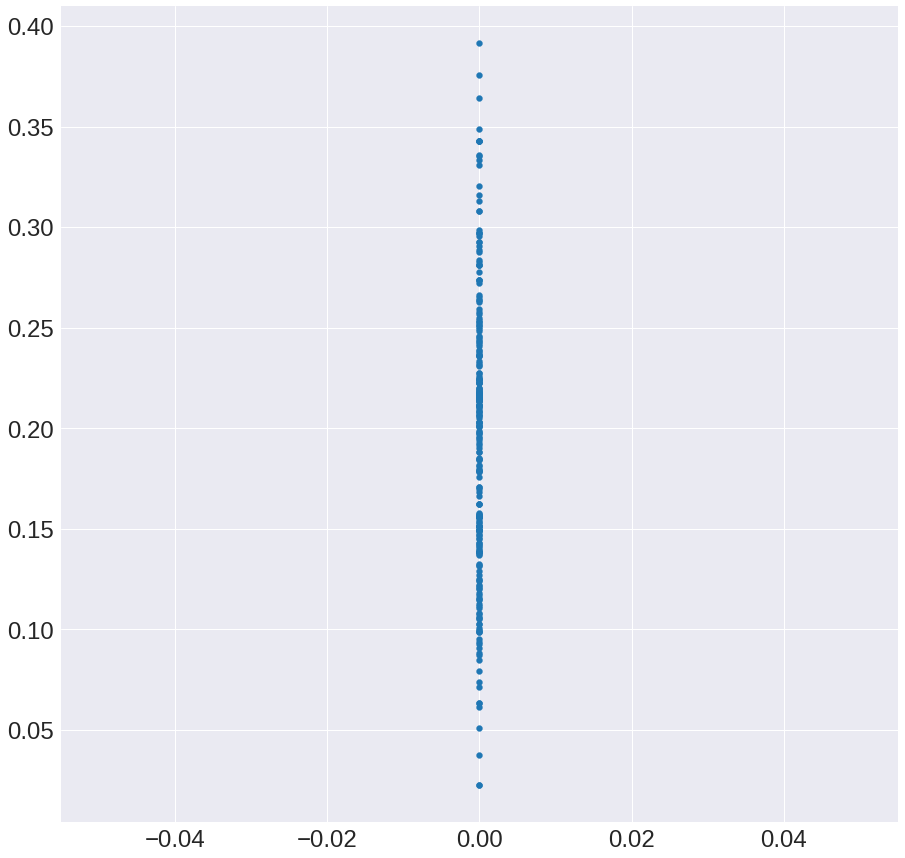

In [157]:
plt.scatter(x = [0] * len(get_gini_coefficients(SA_data_evaluation_limited)),y=sorted(get_gini_coefficients(SA_data_evaluation_limited)))